*First compiled on May 5, 2017. Updated Mar 28, 2018.*   
See the same notebook for Scanpy [0.4.4](https://github.com/theislab/scanpy_usage/blob/17c34b61f76de79bfdea7512f1782bf3f5ecb160/170505_seurat/seurat.ipynb).

*The second dataset added on Sep 8th, 2018 by Abeer Almutairy.

# Clustering 2 3k-PBMCs Datasets (following a Seurat Tutorial)

## Preparing the Data

Scanpy allows to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) standard clustering tutorial as described on http://satijalab.org/seurat/pbmc3k_tutorial.html (July 26, 2017). We gratefully acknowledge  the Seurat authors for publishing the tutorial!

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [ ]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.1 anndata==0.6.4 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
results_file = './write/pmbc3k.h5ad'

In [3]:
results_file2 = './write/pmbc3k2.h5ad'

In [4]:
path = './data/pbmc3k_filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
print (adata)
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var['var_ensemble'] = list(pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[0])

... reading from cache file ./cache/data-pbmc3k_filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
path2 = './data/filtered_matrices_mex/hg19/'
adata2 = sc.read(path2 + 'matrix.mtx', cache=True).T  # transpose the data
print (adata2)
adata2.var_names = pd.read_csv(path2 + 'genes.tsv', header=None, sep='\t')[1]
adata2.obs_names = pd.read_csv(path2 + 'barcodes.tsv', header=None)[0]
adata2.var['var_ensemble']  = list(pd.read_csv(path2 + 'genes.tsv', header=None, sep='\t')[0])

... reading from cache file ./cache/data-filtered_matrices_mex-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2900 × 32738 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
print("# all genes: ", len(list(adata.var_names)))
print ("# distinct genes: ", len(list(set(adata.var_names))))
print ("--------------")
print("# all genes(ensemble): ", len(list(adata.var['var_ensemble'])))
print ("# distinct genes(ensemble): ", len(list(set(adata.var['var_ensemble']))))

# all genes:  32738
# distinct genes:  32643
--------------
# all genes(ensemble):  32738
# distinct genes(ensemble):  32738


In [7]:
print ("# all genes: ", len(list(adata2.var_names)))
print ("# distinct genes: ", len(list(set(adata2.var_names))))
print ("--------------")
print ("# all genes(ensemble): ", len(list(adata2.var['var_ensemble'])))
print ("# distinct genes(ensemble): ", len(list(set(adata2.var['var_ensemble']))))

# all genes:  32738
# distinct genes:  32643
--------------
# all genes(ensemble):  32738
# distinct genes(ensemble):  32738


In [8]:
print("# of Common gennes b/w the two datasets: ", len(set(adata.var_names) & set(adata2.var_names)))
#Just to test number of common genes in both datasets if we remove the ".*" that make them distinct.
mylist = adata.var_names
mylist2 = adata2.var_names
#-----------------------------------
mylist = [s.partition('.')[0] for s in mylist]
mylist2 = [s.partition('.')[0] for s in mylist2]
#-----------------------------------
print("# of Common gene names b/w the two datasets if we remove (.*): ", len(set(mylist) & set(mylist2)))
print("# of Common gennes b/w the two datasets(ensemble): ", len(set(adata.var['var_ensemble']) & set(adata2.var['var_ensemble'])))

# of Common gennes b/w the two datasets:  32643
# of Common gene names b/w the two datasets if we remove (.*):  29131
# of Common gennes b/w the two datasets(ensemble):  32738


<font color="blue">The following scripts make the gene names unique (var_names) by indexing the duplicates.</font>
<br/><font color=red>Note: the ensemble IDs are unique in both datasets.</font>

In [9]:
adata.var_names_make_unique()
print (adata)

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'var_ensemble'


In [10]:
adata2.var_names_make_unique()
print (adata2)

AnnData object with n_obs × n_vars = 2900 × 32738 
    var: 'var_ensemble'


In [12]:
print (adata2.var_names)

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)


In [13]:
print (adata.var_names)

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)


## Preprocessing

### Basic Filtering <I>-- Extreme Outliers Removal</I>

<font color="blue">In the following steps, we filter out the cells with less than 200 genes, and we filter out genes that are expressed in less than 3 cells. We use the same cutoffs for both datasets. Although, the cutoffs are more more stringent for one of the datasets than the other.</font>

In [14]:
#Filter cell outliers based on counts and numbers of genes expressed.
#For instance, only keep cells with at least min_counts counts or min_genes genes expressed. This is to filter measurement outliers, i.e., “unreliable” observations.
#Only provide one of the optional parameters min_counts, min_genes, max_counts, max_genes per call.
sc.pp.filter_cells(adata, min_genes=200)

#Filter genes based on number of cells or counts.
#Keep genes that have at least min_counts counts or are expressed in at least min_cells cells or have at most max_counts counts or are expressed in at most max_cells cells.
#Only provide one of the optional parameters min_counts, min_cells, max_counts, max_cells per call.
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
#Filter cell outliers based on counts and numbers of genes expressed.
#For instance, only keep cells with at least min_counts counts or min_genes genes expressed. This is to filter measurement outliers, i.e., “unreliable” observations.
#Only provide one of the optional parameters min_counts, min_genes, max_counts, max_genes per call.
sc.pp.filter_cells(adata2, min_genes=200)

#Filter genes based on number of cells or counts.
#Keep genes that have at least min_counts counts or are expressed in at least min_cells cells or have at most max_counts counts or are expressed in at most max_cells cells.
#Only provide one of the optional parameters min_counts, min_cells, max_counts, max_cells per call.
sc.pp.filter_genes(adata2, min_cells=3)

In [16]:
print("The data shape after filtering:\n", adata.shape)

The data shape after filtering:
 (2700, 13714)


In [17]:
print ("The data shape after filtering:\n",adata2.shape)

The data shape after filtering:
 (2900, 13067)


<font color=red><B>Observation: </B></font></br>
<font color=blue>The number of genes that have cell counts less than 3 is larger in the second dataset. The number of vars after filtering the genes is 13067 whereas in the first dataset, the number of genes after the filtering is 13714.

==> the gene filtering is more stringent for the 2nd dataset.</font>

---------------------------

<font color="blue">Here, we just inspect the sparse dataframe for the datasets after normalization.</font> (--Skip if not needed)

In [ ]:
#df.reset_index(drop=True, inplace=True)
#df = pd.DataFrame()
df = pd.SparseDataFrame(adata.X, index=adata.obs_names, columns=adata.var_names, copy=True)
print(df.shape)
df = pd.concat([df,pd.DataFrame(df.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df_min = pd.DataFrame(df.min(axis=0, skipna=True),columns=['Min'])
df_max = pd.DataFrame(df.max(axis=0, skipna=True),columns=['Max'])
df_mean = pd.DataFrame(df.mean(axis=0, skipna=True),columns=['Mean'])
df_std = pd.DataFrame(df.std(axis=0, skipna=True),columns=['Std'])
df_var = pd.DataFrame(df.var(axis=0, skipna=True),columns=['Var'])

df = pd.concat([df, df_min.T])
df = pd.concat([df, df_max.T])  
df = pd.concat([df, df_mean.T]) 
df = pd.concat([df, df_std.T]) 
df = pd.concat([df, df_var.T]) 
head(df) 

In [ ]:
#df.reset_index(drop=True, inplace=True)
#df = pd.DataFrame()
df2 = pd.SparseDataFrame(adata2.X, index=adata2.obs_names, columns=adata2.var_names, copy=True)
print (df2.shape)
df2 = pd.concat([df2,pd.DataFrame(df2.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df2_min = pd.DataFrame(df2.min(axis=0, skipna=True),columns=['Min'])
df2_max = pd.DataFrame(df2.max(axis=0, skipna=True),columns=['Max'])
df2_mean = pd.DataFrame(df2.mean(axis=0, skipna=True),columns=['Mean'])
df2_std = pd.DataFrame(df2.std(axis=0, skipna=True),columns=['Std'])
df2_var = pd.DataFrame(df2.var(axis=0, skipna=True),columns=['Var'])

df2 = pd.concat([df2, df2_min.T])
df2 = pd.concat([df2, df2_max.T])  
df2 = pd.concat([df2, df2_mean.T])
df2 = pd.concat([df2, df2_std.T]) 
df2 = pd.concat([df2, df2_var.T]) 
df2.head()

### Other Sources of Variation

#### Mitochondrial Genes

Plot some information about mitochondrial genes, important for quality control. Note that you can also retrieve mitochondrial genes using `sc.queries.mitochondrial_genes_biomart('www.ensembl.org', 'mmusculus')`.

In [18]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
print (mito_genes)
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
print("==================")
print("Min. % mito: ", adata.obs['percent_mito'].min())
print("Max. % mito: ", adata.obs['percent_mito'].max())
print("Mean. % mito: ", adata.obs['percent_mito'].mean())
print("==================")
print("Min. count of genes: ", adata.obs['n_genes'].min())
print("Max. count of genes: ", adata.obs['n_genes'].max())
print("Mean. count of genes: ", adata.obs['n_genes'].mean())

['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']
Min. % mito:  0.0
Max. % mito:  0.22569028
Mean. % mito:  0.02216642
Min. count of genes:  212
Max. count of genes:  3422
Mean. count of genes:  846.9940740740741


In [19]:
mito_genes2 = [name for name in adata2.var_names if name.startswith('MT-')]
print (mito_genes2)
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata2.obs['percent_mito'] = np.sum(adata2[:, mito_genes2].X, axis=1).A1 / np.sum(adata2.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata2.obs['n_counts'] = adata2.X.sum(axis=1).A1
print("==================")
print("Min. % mito: ", adata2.obs['percent_mito'].min())
print("Max. % mito: ", adata2.obs['percent_mito'].max())
print("Mean. % mito: ", adata2.obs['percent_mito'].mean())
print("==================")
print("Min. count of genes: ", adata2.obs['n_genes'].min())
print("Max. count of genes: ", adata2.obs['n_genes'].max())
print("Mean. count of genes: ", adata2.obs['n_genes'].mean())

['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']
Min. % mito:  0.0010219724
Max. % mito:  0.20880914
Mean. % mito:  0.02050412
Min. count of genes:  258
Max. count of genes:  2376
Mean. count of genes:  758.2631034482758


---------------------------

A violin plot of the computed quality measures.

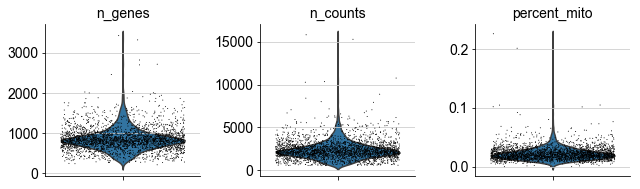

In [20]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

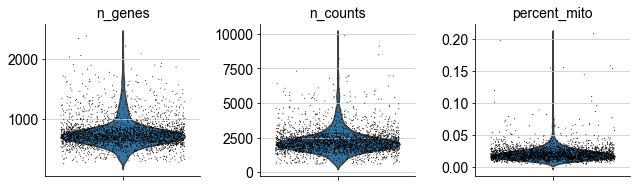

In [21]:
sc.pl.violin(adata2, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

<font color=Red><B>General Observation:</B></font><br/>
<font color=blue>Based on the plots above, it can be seen that the second dataset has smaller counts average for genes in general and for mito genes in particular compared to the first dataset. Also, the second dataset has higher variability in its counts than the first one.</font>

---------------------------

We want to remove cells that have <B>too many mitochondrial genes expressed</B> or <B>too many total counts</B>. In order to do that, we can use the scatter plots to pick a threshold for filtering.

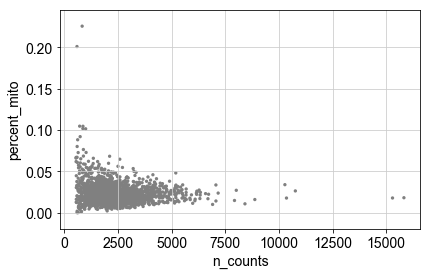

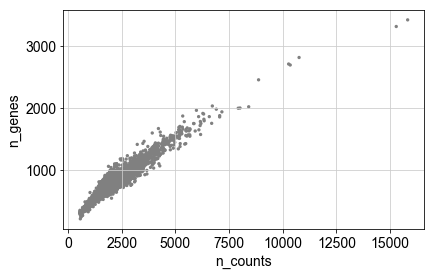

In [22]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

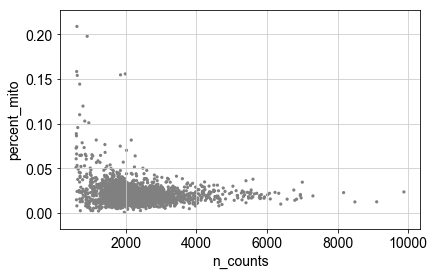

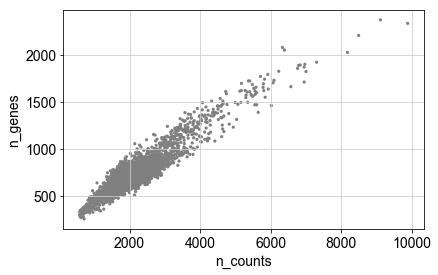

In [23]:
sc.pl.scatter(adata2, x='n_counts', y='percent_mito')
sc.pl.scatter(adata2, x='n_counts', y='n_genes')

#### Filtering Mitochondrial Genes

<font color=blue>Before we start filtering the data using the cutoffs we picked based on the basic inspection and the plots above, there are many common ways we could try to find the outliers. For example, <B><I>interquartile range method</B></I>.</font>

In [24]:
from scipy.stats import iqr
#print(adata.obs['n_genes'])
def outliers_iqr(dat):
    quartile_1, quartile_3 = np.percentile(dat, [25, 75])
    iqr_ = iqr(dat) #iqr = quartile_3 - quartile_1
    print ("IQR = ", iqr_)
    print ("Q1 = ", quartile_1)
    print ("Q3 = ", quartile_3)
    lower_bound = quartile_1 - (iqr_ * 1.5)
    upper_bound = quartile_3 + (iqr_ * 1.5)
    print("---------------------")
    print ("The cutoffs are: \nlower=", lower_bound, ", upper=", upper_bound)
    return np.where((dat > upper_bound) | (dat < lower_bound))

In [25]:
data = outliers_iqr(adata.obs['n_genes'])
print("--------------------------------------")
print("The list of outliers if we use this method: ("+str(len(data[0]))+" outliers)")
print("--------------------------------------")
print(adata.obs.iloc[data].head(5))

IQR =  263.25
Q1 =  690.0
Q3 =  953.25
---------------------
The cutoffs are: 
lower= 295.125 , upper= 1348.125
--------------------------------------
The list of outliers if we use this method: (155 outliers)
--------------------------------------
                  n_genes  percent_mito  n_counts
0                                                
AAACATTGAGCTAC-1     1352      0.037936    4903.0
AAAGCAGATATCGG-1     1424      0.013962    4584.0
AAAGGCCTGTCTAG-1     1446      0.015283    4973.0
AAATCAACCCTATT-1     1545      0.024313    5676.0
AAATCATGACCACA-1     1368      0.045785    4128.0


In [26]:
data2 = outliers_iqr(adata2.obs['n_genes'])
print("--------------------------------------")
print("The list of outliers if we use this method: ("+str(len(data2[0]))+" outliers)")
print("--------------------------------------")
print(adata2.obs.iloc[data2].head(5))

IQR =  188.0
Q1 =  634.0
Q3 =  822.0
---------------------
The cutoffs are: 
lower= 352.0 , upper= 1104.0
--------------------------------------
The list of outliers if we use this method: (261 outliers)
--------------------------------------
                  n_genes  percent_mito  n_counts
0                                                
AAAGAGACGATAGA-1     1162      0.018868    3180.0
AAAGCAGAGTAAAG-1     2210      0.012600    8492.0
AACACGTGCCGATA-1     1243      0.018223    3073.0
AACAGAGACTCGCT-1     1182      0.031500    4127.0
AACCGATGTGTGGT-1     1624      0.019741    5167.0


---------------------------

<font color="blue">Here, we apply the same cutoffs (from the original notebook) for both datasets. As it's mentioned above, this will result in more stringent filtering for one of the datasets. The cutoff for numbers of genes per cell is 2500, and the threshold for the mito percentage is 0.05.</font> 

In [27]:
adata = adata[adata.obs['n_genes'] < 2500, :]
print("After filtering counts: ", adata.shape)
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print("After filtering mito%: ", adata.shape)

After filtering counts:  (2695, 13714)
After filtering mito%:  (2638, 13714)


In [28]:
adata2 = adata2[adata2.obs['n_genes'] < 2500, :]
print("After filtering counts: ", adata2.shape)
adata2 = adata2[adata2.obs['percent_mito'] < 0.05, :]
print("After filtering mito%: ", adata2.shape)

After filtering counts:  (2900, 13067)
After filtering mito%:  (2849, 13067)


---------------------------

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by `sc.pp.log1p`.

In [29]:
#Logarithmize the data matrix.
#Computes X = log(X + 1), where log denotes the natural logarithm.
adata.raw = sc.pp.log1p(adata, copy=True)

In [30]:
#Logarithmize the data matrix.
#Computes X = log(X + 1), where log denotes the natural logarithm.
adata2.raw = sc.pp.log1p(adata2, copy=True)

In [31]:
print(adata)

AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'


In [32]:
print(adata2)

AnnData object with n_obs × n_vars = 2849 × 13067 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'


### Normalization

Per-cell normalize the data matrix $\mathbf{X}$. Many people would consider the normalized data matrix as the "relevant data" for visualization and differential testing (assessing feature importance). Until a common viewpoint is reached on this, the decision of what to consider "raw", is up to the user. We tend to recommend to use the normalized data for visualization and differential testing even though here, we use the non-normalized data for the sake of consistency with the Seurat tutorial.

In [33]:
#Normalize total counts per cell.
#Normalize each cell by total counts over all genes, 
#so that every cell has the same total count after normalization.
#counts_per_cell_after : float or None, optional (default: None)
#If None, after normalization, each cell has a total count equal to 
#the median of the counts_per_cell before normalization. why 1e4?
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [34]:
#Normalize total counts per cell.
#Normalize each cell by total counts over all genes, 
#so that every cell has the same total count after normalization.
#counts_per_cell_after : float or None, optional (default: None)
#If None, after normalization, each cell has a total count equal to 
#the median of the counts_per_cell before normalization. why 1e4?
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)

---------------------------

<font color="blue">Here, we just inspect the sparse dataframe for the datasets after normalization.</font> (Not needed!)

In [ ]:
#df.reset_index(drop=True, inplace=True)
#df = pd.DataFrame()
df = pd.SparseDataFrame(adata.X, index=adata.obs_names, columns=adata.var_names, copy=True)
print(df.shape)
df = pd.concat([df,pd.DataFrame(df.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df_min = pd.DataFrame(df.min(axis=0, skipna=True),columns=['Min'])
df_max = pd.DataFrame(df.max(axis=0, skipna=True),columns=['Max'])
df_mean = pd.DataFrame(df.mean(axis=0, skipna=True),columns=['Mean'])
df_std = pd.DataFrame(df.std(axis=0, skipna=True),columns=['Std'])
df_var = pd.DataFrame(df.var(axis=0, skipna=True),columns=['Var'])

df = pd.concat([df, df_min.T])
df = pd.concat([df, df_max.T])  
df = pd.concat([df, df_mean.T]) 
df = pd.concat([df, df_std.T]) 
df = pd.concat([df, df_var.T]) 
df.tail(10)

In [ ]:
#df.reset_index(drop=True, inplace=True)
#df = pd.DataFrame()
df2 = pd.SparseDataFrame(adata2.X, index=adata2.obs_names, columns=adata2.var_names, copy=True)
print (df2.shape)
df2 = pd.concat([df2,pd.DataFrame(df2.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df2_min = pd.DataFrame(df2.min(axis=0, skipna=True),columns=['Min'])
df2_max = pd.DataFrame(df2.max(axis=0, skipna=True),columns=['Max'])
df2_mean = pd.DataFrame(df2.mean(axis=0, skipna=True),columns=['Mean'])
df2_std = pd.DataFrame(df2.std(axis=0, skipna=True),columns=['Std'])
df2_var = pd.DataFrame(df2.var(axis=0, skipna=True),columns=['Var'])

df2 = pd.concat([df2, df2_min.T])
df2 = pd.concat([df2, df2_max.T])  
df2 = pd.concat([df2, df2_mean.T])
df2 = pd.concat([df2, df2_std.T]) 
df2 = pd.concat([df2, df2_var.T]) 
df2.tail(10)

### Identifying Highly-Variable Genes

    extracting highly variable genes
    Gene indices [7854] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:00.29)


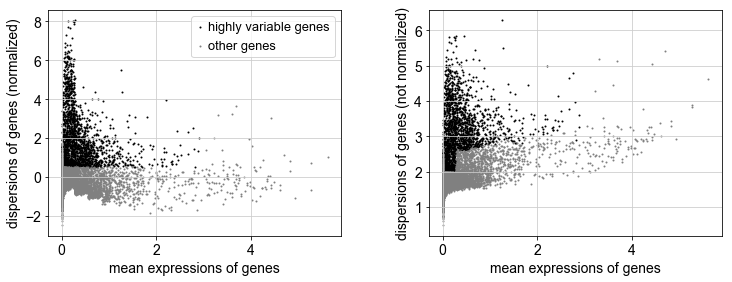

In [35]:
#Extract highly variable genes.
#If trying out parameters, pass the data matrix instead of AnnData.
#The normalized dispersion is obtained by scaling with the mean and standard deviation 
#of the dispersions for genes falling into a given bin for mean expression of genes. 
#This means that for each bin of mean expression, highly variable genes are selected.
sc.settings.verbosity = 4
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
#.means, .dispersions, .dispersions_norm
#print(filter_result)
sc.pl.filter_genes_dispersion(filter_result)

    extracting highly variable genes
    Gene indices [7467, 10203] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:00.18)


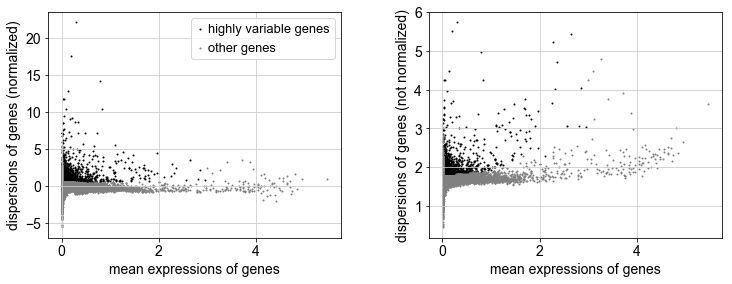

In [36]:
#Extract highly variable genes.
#If trying out parameters, pass the data matrix instead of AnnData.
#The normalized dispersion is obtained by scaling with the mean and standard deviation 
#of the dispersions for genes falling into a given bin for mean expression of genes. 
#This means that for each bin of mean expression, highly variable genes are selected.
sc.settings.verbosity = 4
filter_result2 = sc.pp.filter_genes_dispersion(adata2.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
#.means, .dispersions, .dispersions_norm
#print(filter_result2)
sc.pl.filter_genes_dispersion(filter_result2)

---------------------------

<font color="blue">Before we filter the data using the gene subset of the highly expressed genes, let's take a look at the gene numbers.</font>

In [37]:
tmp = adata[:, filter_result.gene_subset].var
print("# of highly expressed genes: ", len(tmp))
print(tmp.head(5))

# of highly expressed genes:  1838
            var_ensemble  n_cells
TNFRSF4  ENSG00000186827      155
CPSF3L   ENSG00000127054      202
ATAD3C   ENSG00000215915        9
C1orf86  ENSG00000162585      501
RER1     ENSG00000157916      608


In [38]:
tmp2 = adata2[:, filter_result2.gene_subset].var
print("# of highly expressed genes: ", len(tmp2))
print(tmp2.head(5))

# of highly expressed genes:  2142
             var_ensemble  n_cells
TNFRSF18  ENSG00000186891      102
B3GALT6   ENSG00000176022       13
ATAD3A    ENSG00000197785       37
MMP23B    ENSG00000189409       37
PRKCZ     ENSG00000067606       61


<font color=blue>Let's find out how many genes are highly expressed in both datasets:</blue>

In [39]:
intersect_names = set([s.split('.')[0] for s in tmp.index]) & set([s2.split('.')[0] for s2 in tmp2.index])
print("Given the cutoffs above, the number of highly expressed genes in both datasets is: ",len(intersect_names))

intersect_ensemble = set(list(tmp['var_ensemble'])) & set(list(tmp2['var_ensemble']))
print("Given the cutoffs above, the number of highly expressed genes (ensemble) in both datasets is: ",len(intersect_ensemble))


Given the cutoffs above, the number of highly expressed genes in both datasets is:  393
Given the cutoffs above, the number of highly expressed genes (ensemble) in both datasets is:  391


<font color=blue>It's clearly seen that the cutoffs we used above for identifying the highly expressed genes are too stringent to integrate the two datasets. In the second section (Integrating the two datasets), we might want to try the parameter <B><I>n_top_genes</I></B> to select the number of highly expressed genes returned by the function for both datasets in order to increase the intersection of genes.</font>

---------------------------

### More Processing

#### Filtering the Data --using the list of highly expressed genes

Actually do the <B>filtering</B> using the list of highly expressed genes we extracted above.

In [40]:
adata = adata[:, filter_result.gene_subset]
print (adata)

View of AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'


In [41]:
adata2 = adata2[:, filter_result2.gene_subset]
print (adata2)

View of AnnData object with n_obs × n_vars = 2849 × 2142 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'


---------------------------

#### Logarithmizing the Data

In [42]:
sc.pp.log1p(adata)

In [43]:
sc.pp.log1p(adata2)

In [ ]:
adata.obs

In [ ]:
adata2.obs

---------------------------

#### Regressing out Unwanted Source of Variation

<B>Regress out</B> effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [45]:
#Regress out unwanted sources of variation.
#Uses simple linear regression.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
print (adata)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.55)
AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'


In [46]:
#Regress out unwanted sources of variation.
#Uses simple linear regression.
sc.pp.regress_out(adata2, ['n_counts', 'percent_mito'])
print (adata2)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06.45)
AnnData object with n_obs × n_vars = 2849 × 2142 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'


---------------------------

In [ ]:
df = pd.SparseDataFrame(adata.X, index=adata.obs_names, columns=adata.var_names, copy=True)
print(df.shape)
df = pd.concat([df,pd.DataFrame(df.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df_min = pd.DataFrame(df.min(axis=0, skipna=True),columns=['Min'])
df_max = pd.DataFrame(df.max(axis=0, skipna=True),columns=['Max'])
df_mean = pd.DataFrame(df.mean(axis=0, skipna=True),columns=['Mean'])
df_std = pd.DataFrame(df.std(axis=0, skipna=True),columns=['Std'])
df_var = pd.DataFrame(df.var(axis=0, skipna=True),columns=['Var'])

df = pd.concat([df, df_min.T])
df = pd.concat([df, df_max.T])  
df = pd.concat([df, df_mean.T]) 
df = pd.concat([df, df_std.T]) 
df = pd.concat([df, df_var.T]) 
df.tail(10)

In [ ]:
df2 = pd.SparseDataFrame(adata2.X, index=adata2.obs_names, columns=adata2.var_names, copy=True)
print (df2.shape)
df2 = pd.concat([df2,pd.DataFrame(df2.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df2_min = pd.DataFrame(df2.min(axis=0, skipna=True),columns=['Min'])
df2_max = pd.DataFrame(df2.max(axis=0, skipna=True),columns=['Max'])
df2_mean = pd.DataFrame(df2.mean(axis=0, skipna=True),columns=['Mean'])
df2_std = pd.DataFrame(df2.std(axis=0, skipna=True),columns=['Std'])
df2_var = pd.DataFrame(df2.var(axis=0, skipna=True),columns=['Var'])

df2 = pd.concat([df2, df2_min.T])
df2 = pd.concat([df2, df2_max.T])  
df2 = pd.concat([df2, df2_mean.T])
df2 = pd.concat([df2, df2_std.T]) 
df2 = pd.concat([df2, df2_var.T]) 
df2.tail(10)

#### Scaling the Data

In [47]:
#Scale data to unit variance and zero mean.
#The (annotated) data matrix of shape n_obs × n_vars. 
#Rows correspond to cells and columns to genes.
#max_value : float or None, optional (default: None)
#Clip (truncate) to this value after scaling. If None, do not clip.
sc.pp.scale(adata, max_value=10)

    ... clipping at max_value 10


In [48]:
#Scale data to unit variance and zero mean.
#The (annotated) data matrix of shape n_obs × n_vars. 
#Rows correspond to cells and columns to genes.
#max_value : float or None, optional (default: None)
#Clip (truncate) to this value after scaling. If None, do not clip.
sc.pp.scale(adata2, max_value=10)

    ... clipping at max_value 10


---------------------------

In [ ]:
df = pd.SparseDataFrame(adata.X, index=adata.obs_names, columns=adata.var_names, copy=True)
print(df.shape)
df = pd.concat([df,pd.DataFrame(df.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df_min = pd.DataFrame(df.min(axis=0, skipna=True),columns=['Min'])
df_max = pd.DataFrame(df.max(axis=0, skipna=True),columns=['Max'])
df_mean = pd.DataFrame(df.mean(axis=0, skipna=True),columns=['Mean'])
df_std = pd.DataFrame(df.std(axis=0, skipna=True),columns=['Std'])
df_var = pd.DataFrame(df.var(axis=0, skipna=True),columns=['Var'])

df = pd.concat([df, df_min.T])
df = pd.concat([df, df_max.T])  
df = pd.concat([df, df_mean.T]) 
df = pd.concat([df, df_std.T]) 
df = pd.concat([df, df_var.T]) 
df.tail(10)

In [ ]:
df2 = pd.SparseDataFrame(adata2.X, index=adata2.obs_names, columns=adata2.var_names, copy=True)
print (df2.shape)
df2 = pd.concat([df2,pd.DataFrame(df2.sum(axis=1, skipna=True),columns=['Total'])],axis=1)
df2_min = pd.DataFrame(df2.min(axis=0, skipna=True),columns=['Min'])
df2_max = pd.DataFrame(df2.max(axis=0, skipna=True),columns=['Max'])
df2_mean = pd.DataFrame(df2.mean(axis=0, skipna=True),columns=['Mean'])
df2_std = pd.DataFrame(df2.std(axis=0, skipna=True),columns=['Std'])
df2_var = pd.DataFrame(df2.var(axis=0, skipna=True),columns=['Var'])

df2 = pd.concat([df2, df2_min.T])
df2 = pd.concat([df2, df2_max.T])  
df2 = pd.concat([df2, df2_mean.T])
df2 = pd.concat([df2, df2_std.T]) 
df2 = pd.concat([df2, df2_var.T]) 
df2.tail(10)

Save the results.

In [49]:
adata.write(results_file)

In [50]:
adata2.write(results_file2)

## PCA

Compute PCA and make a scatter plot.

In [51]:
#Computes PCA coordinates, loadings and variance decomposition. 
#n_comps : int, optional (default: 50); Number of principal components to compute.
#zero_center : bool or None, optional (default: True); If True, compute standard PCA from covariance matrix. If False, omit zero-centering variables (uses TruncatedSVD from scikit-learn), which allows to handle sparse input efficiently.
#svd_solver : str, optional (default: ‘auto’); SVD solver to use. Either ‘arpack’ for the ARPACK wrapper in SciPy (scipy.sparse.linalg.svds), or ‘randomized’ for the randomized algorithm due to Halko (2009). ‘auto’ chooses automatically depending on the size of the problem.
#random_state : int, optional (default: 0); Change to use different intial states for the optimization.
sc.tl.pca(adata)

    computing PCA with n_comps = 50
        finished (0:00:00.44)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


In [52]:
#Computes PCA coordinates, loadings and variance decomposition. 
#n_comps : int, optional (default: 50); Number of principal components to compute.
#zero_center : bool or None, optional (default: True); If True, compute standard PCA from covariance matrix. If False, omit zero-centering variables (uses TruncatedSVD from scikit-learn), which allows to handle sparse input efficiently.
#svd_solver : str, optional (default: ‘auto’); SVD solver to use. Either ‘arpack’ for the ARPACK wrapper in SciPy (scipy.sparse.linalg.svds), or ‘randomized’ for the randomized algorithm due to Halko (2009). ‘auto’ chooses automatically depending on the size of the problem.
#random_state : int, optional (default: 0); Change to use different intial states for the optimization.
sc.tl.pca(adata2)

    computing PCA with n_comps = 50
        finished (0:00:00.42)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


In [53]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat

In [54]:
adata2.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat

---------------------------

<font color=blue>In the following step, we rank the genes under each single PC using pca loadings for both datasets to see if we can find any known marker genes in the PCs.</font>

In [55]:
print(adata.varm['PCs'].shape)
loadings = pd.DataFrame(adata.varm['PCs'], index=adata.var_names, copy=True)
PCs_df=pd.DataFrame(index=range(1,len(adata.var_names)+1))
for i in range(50):
    loadings=loadings.sort_values(i, axis=0, ascending=False, kind='quicksort', na_position='last')
    PCs_df.insert(loc=i, column='PC'+str(i+1), value=list(loadings[loadings.columns[i]].index), allow_duplicates=True)
PCs_df.shape
PCs_df.head(10)

(1838, 50)


PC1     PC2        PC3        PC4            PC5      PC6       PC7  \
1     CST3    NKG7        PF4      CD79A         FCGR3A     GZMK      SELL   
2   TYROBP    GZMB       PPBP   HLA-DQA1  CTD-2006K23.1     CCL5       LTB   
3     FCN1    PRF1       SDPR      CD79B         IFITM3     LYAR      ICOS   
4     LST1    CST7      SPARC      MS4A1           ABI3     IL32   TNFRSF4   
5     AIF1    GZMA      GNG11   HLA-DQB1          CEBPB    KLRG1  TNFRSF25   
6   S100A8  FGFBP2  HIST1H2AC   HLA-DPB1           C1QA    TIGIT       MAL   
7     TYMP    GNLY        GP9   HLA-DPA1        TNFSF10  JAKMIP1     PLBD1   
8   LGALS2    CTSW       NRGN   HLA-DRB1       TNFRSF1B      CD2    IGFBP7   
9   FCER1G   SPON2      TUBB1      TCL1A        SMPDL3A     GZMA     KIF5B   
10  LGALS1    CCL4      RGS18  LINC00926          LYPD2   GPR171     ITM2A   

         PC8      PC9      PC10     ...         PC41     PC42           PC43  \
1     FCER1A     GZMH     IFIT1     ...        LYRM2   TMEM18          TAPBP   
2    CLEC10A  SLC40A1      OASL     ...       TANGO6  TMEM222         MAP2K7   
3       CD1C    FCRL6    UBE2L6     ...        JKAMP     IRF7          PACS1   
4       ENHO    FOLR3  APOBEC3B     ...        THOC7    SIRT6          ELOF1   
5   SERPINF1    TIGIT      GBP1     ...        PTGDR   EIF1AY        SLC39A1   
6       GZMH  S100A12      GMPR     ...         NIT2    ZFP69  RP11-727F15.9   
7    ARL6IP5   HEXIM2     TREX1     ...        PRKCD    OXLD1          ZMAT5   
8       PLD4   CCL4L1   TNFSF10     ...      DNAJC15   GPR183          PI4KB   
9      TIGIT    ABCC3     IFIT2     ...       ATP5C1  TMEM165         CAMK1D   
10  HLA-DPB1    ARMC7     IFI35     ...         AAR2      MFF          MKLN1   

             PC44     PC45        PC46     PC47     PC48        PC49  \
1           PCSK7      LBR      ORMDL2     LRBA     ABT1       TRPV2   
2          ARPP19   CEP164       IFI44     GBP1   RNF125       CPNE2   
3           TRPV2   FN3KRP       NUPL2  CCDC174    WDR45  AC093323.3   
4            TLE4     SDHB     C5orf56     RBM3    USP20      MARCH5   
5           GTF3A     ACP1  AC113189.5    NEIL1  CARHSP1        FNTA   
6          NUDCD1    DCAF5       STX16  TMEM199    MAT2A       SYVN1   
7            BBC3      MFF     NCKAP1L   MARCH5  B4GALT4       PCGF1   
8         PLEKHJ1    TCEA2      SNAP47    VPS28      GNS     PLEKHA3   
9   CTC-444N24.11  ATP6V1F        VMAC     RIC3     SCP2        SND1   
10          UBAC2     DDX1       CDC40    HCFC2    CWC15      SELPLG   

          PC50  
1   BZRAP1-AS1  
2      LAMTOR5  
3     C9orf142  
4       GGNBP2  
5        HDAC5  
6     PAFAH1B1  
7        ACTR2  
8         RELT  
9       R3HDM1  
10       ARL4A  

[10 rows x 50 columns]

In [56]:
print(adata2.varm['PCs'].shape)
loadings2 = pd.DataFrame(adata2.varm['PCs'], index=adata2.var_names, copy=True)
PCs_df2=pd.DataFrame(index=range(1,len(adata2.var_names)+1))
for i in range(50):
    loadings2=loadings2.sort_values(i, axis=0, ascending=False, kind='quicksort', na_position='last')
    PCs_df2.insert(loc=i, column='PC'+str(i+1), value=list(loadings2[loadings2.columns[i]].index), allow_duplicates=True)
PCs_df2.shape
PCs_df2.head(10)

(2142, 50)


PC1        PC2       PC3            PC4       PC5      PC6  \
1       CST3      CD79A     CD79A          MS4A7    LILRA4     IL32   
2       FCN1      MS4A1     MS4A1           C1QA     PTCRA     CCL5   
3        LYZ      TCL1A  HLA-DPB1         CDKN1C    LRRC26     CD8A   
4   TMEM176B        LTB  HLA-DPA1  RP11-290F20.3      PLD4     CD8B   
5     S100A9      CD79B  HLA-DQA2          HMOX1  SERPINF1   ZNF683   
6       LST1     VPREB3  HLA-DQA1         FCGR3A  PPP1R14B     LYAR   
7   SERPINA1    HLA-DRA     CD79B            CKB     DERL3   S100A6   
8       CD68  LINC00926     TCL1A         IFITM3     IL3RA  S100A10   
9        CFD      BANK1      GZMB          LYPD2      TPM2     LAG3   
10      SPI1      FCER2  HLA-DRB1           VMO1      MZB1     GZMH   

           PC7            PC8       PC9           PC10   ...           PC41  \
1          CLU           CD8B   CLEC10A           GZMK   ...         MRPL10   
2         PPBP           GZMH    FCER1A          DUSP2   ...           MPP1   
3          PF4           CD8A      CD1C           CD8B   ...          PRKCB   
4         NRGN         FGFBP2       GSN           XCL2   ...       CD27-AS1   
5        GNG11           CCR7      CPVL           XCL1   ...          CIDEB   
6        SPARC         ZNF683    LGALS2           CCL5   ...         CCDC34   
7   AP001189.4           GZMB      LMNA          KLRC1   ...    MIR4435-1HG   
8        TUBB1          ASCL2  HLA-DQA1           SELL   ...          MFSD1   
9     MAP3K7CL         PRSS23       CLU           LYAR   ...          NMUR1   
10      ITGA2B  RP11-291B21.2     PTGS1  RP11-291B21.2   ...          KIFC3   

       PC42      PC43           PC44           PC45          PC46     PC47  \
1      H1FX     INTS9           GMFB         MAPK14          MT2A     BRD7   
2      PKN2    TADA2B         KBTBD3         DIABLO          AFF3    KMT2C   
3     LEMD3  HIST1H1B          STAT4          MTSS1  RP11-94L15.2    FTSJ2   
4   TRMT61A     CDC23         PRSS57  RP11-452F19.3          BATF     SNF8   
5    TCEAL4     EPS15          USP28          FCRL1         WDFY1  FAM105B   
6     ALOX5     BAHD1  RP11-452F19.3          DDIT3       ST3GAL4    HERC1   
7     PTTG1    ACOT13             FH        EIF2AK1    AC006129.2    SMKR1   
8     ACOX1     CWC25        PPP1R37        METTL7A          PLK3    LIMA1   
9     KCTD7     ZMYM2          GALK1          GSTT1          CISH     KLF3   
10     USP8    TMIGD2          ATXN2           LAG3         DGCR8   TRIM21   

         PC48          PC49    PC50  
1       PANK2         SIN3A  TNRC6C  
2       DDX23         UBE4B   PYCRL  
3        ZEB2        MLLT11    GBP4  
4        RFC4  RP11-94L15.2   COX18  
5     SLC25A4         FASLG   PCF11  
6     GPATCH8         PRKCQ    BBS2  
7       GMEB1        EIF4G3  PIK3CG  
8        MT1F      MAPKAPK2  GOLGA5  
9       BCAS2         PATL2  IL17RA  
10  C10orf118        SCPEP1  ARGLU1  

[10 rows x 50 columns]

<B><font color=red>-------------------------------- For testing purposes! Don't run! ------------------------------------------</font></B>

In [57]:
# if you want to look for a specific gene in the previous PCs dataframe, 
# change the following variables as needed:
g='PPBP'
#-------------------------------------------
test_df=pd.DataFrame(index=range(1,len(np.where(PCs_df == g)[0])+1))
test_df.insert(loc=0, column='gene_rank', value=list(np.where(PCs_df == g)[0]+1), allow_duplicates=True)
test_df.insert(loc=1, column='PCs', value=list(np.where(PCs_df == g)[1]+1), allow_duplicates=True)
print(test_df.shape)
#Change it to 50 if you want to see all the rows.
test_df.head(10)

#np.where(PCs_df.iloc[1] == 'PBPP') #find the column index for PBPP in row with index 1
#print(np.where(PCs_df == 'PPBP')[0])
#pd.DataFrame(np.where(PCs_df == 'PPBP'),index= columns=['row_index', 'col_index'])

(50, 2)


gene_rank  PCs
1           2    3
2         159    1
3         246    4
4         268   15
5         326   24
6         431   19
7         441   45
8         495   25
9         519   34
10        530   49

In [58]:
# if you want to look for a specific gene in the previous PCs dataframe, 
# change the following variables as needed:
g2='PPBP'
#-------------------------------------------
test_df2=pd.DataFrame(index=range(1,len(np.where(PCs_df2 == g2)[0])+1))
test_df2.insert(loc=0, column='gene_rank', value=list(np.where(PCs_df2 == g2)[0]+1), allow_duplicates=True)
test_df2.insert(loc=1, column='PCs', value=list(np.where(PCs_df2 == g2)[1]+1), allow_duplicates=True)
print(test_df2.shape)
#Change it to 50 if you want to see all the rows.
test_df2.head(10)

#np.where(PCs_df2.iloc[1] == 'PBPP') #find the column index for PBPP in row with index 1
#print(np.where(PCs_df2 == 'PPBP')[0])
#pd.DataFrame(np.where(PCs_df2 == 'PPBP'),index= columns=['row_index', 'col_index'])

(50, 2)


gene_rank  PCs
1           2    7
2          11    8
3          12    9
4          29    5
5         152    6
6         152   10
7         272    1
8         342   17
9         581   16
10        670   34

<B><font color=red>---------------------------------------------------------------------------------------------------------</font></B>

---------------------------

<font color=red><B>From the PCA Loadings above: </B><br/></font><font color=blue>
We selected the following marker genes in the first four PCs:<ul>
<li>1st Dataset: <B>CST3, NKG7, PPBP, CD79A</B></li>
    <li>2nd Dataset: <B>CST3, CD79A, <S>CD79A</S>, MS4A1, MS4A7</B></li></ul>
The two datasets have 2 known markers in their first PCs. However, NKG7 is not found in the second dataset. PPBP is ranked 2nd in PC7 in the second dataset.
<br/><br/>
Below, we plot the PCA with different components (PCs):
</font>

(2638, 50)


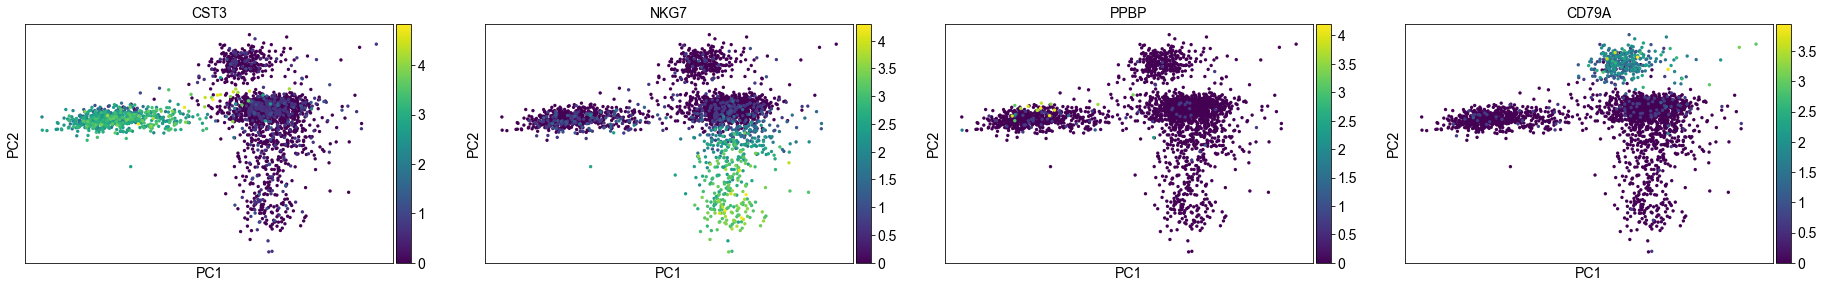

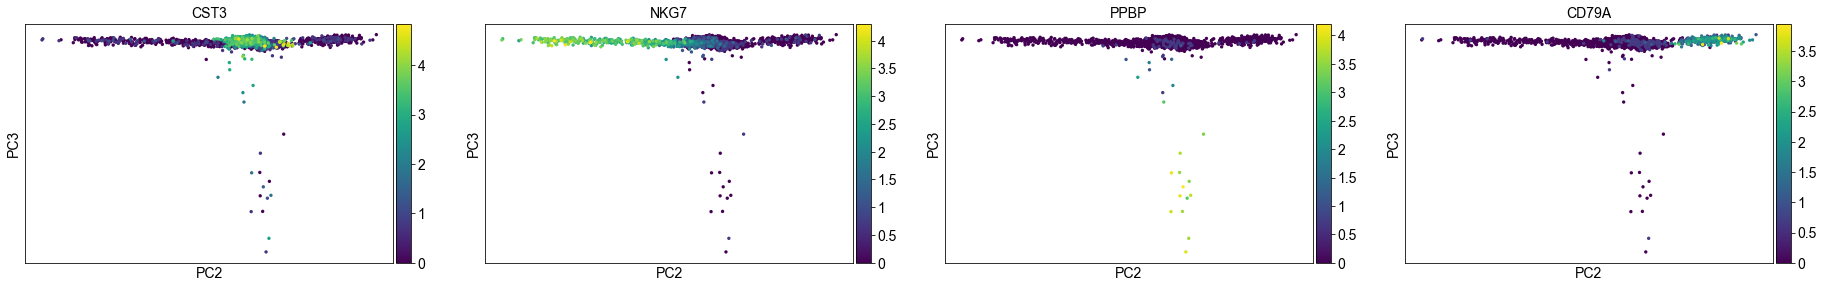

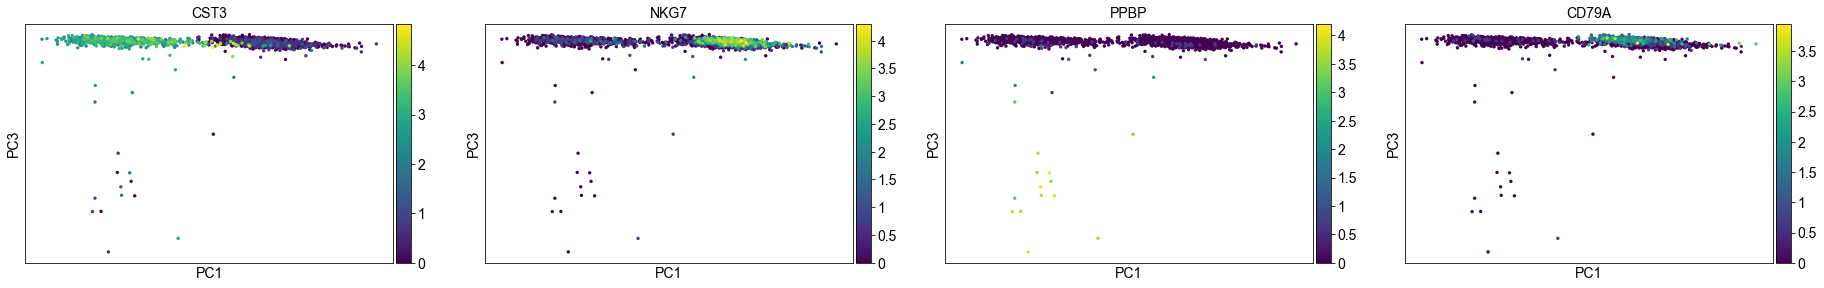

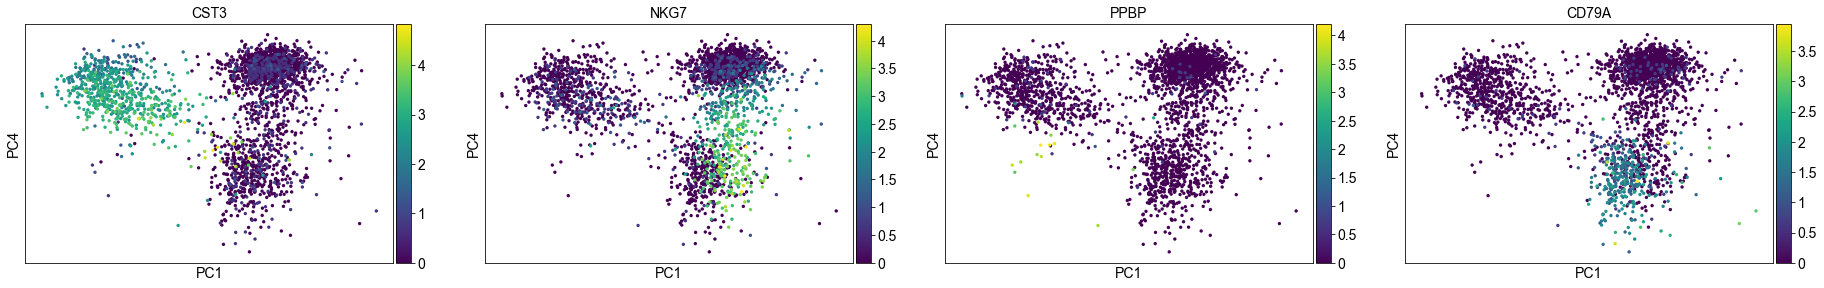

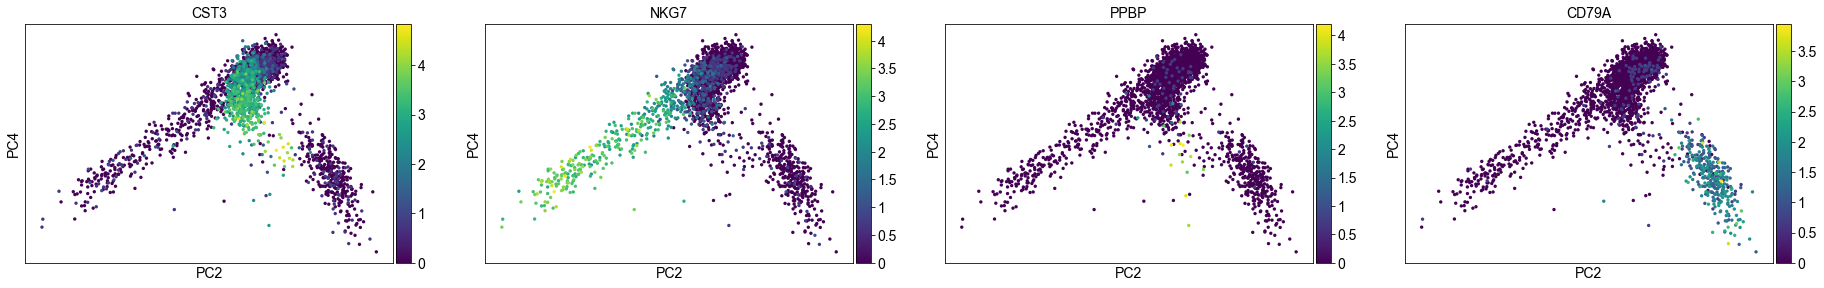

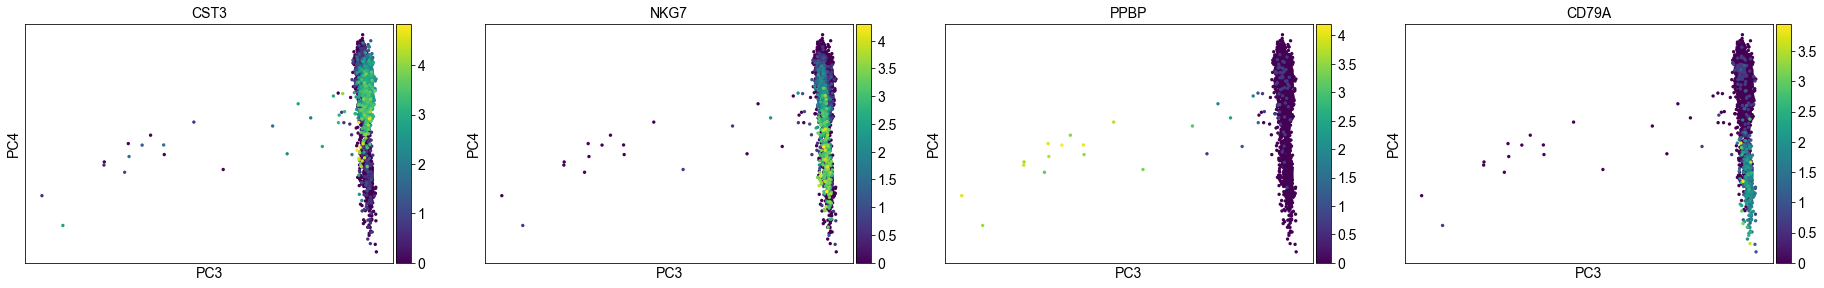

In [59]:
print (adata.obsm['X_pca'].shape)
sc.pl.pca_scatter(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'])
sc.pl.pca_scatter(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'],components='2,3')
sc.pl.pca_scatter(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'],components='1,3')
sc.pl.pca_scatter(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'],components='1,4')
sc.pl.pca_scatter(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'],components='2,4')
sc.pl.pca_scatter(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'],components='3,4')

(2849, 50)


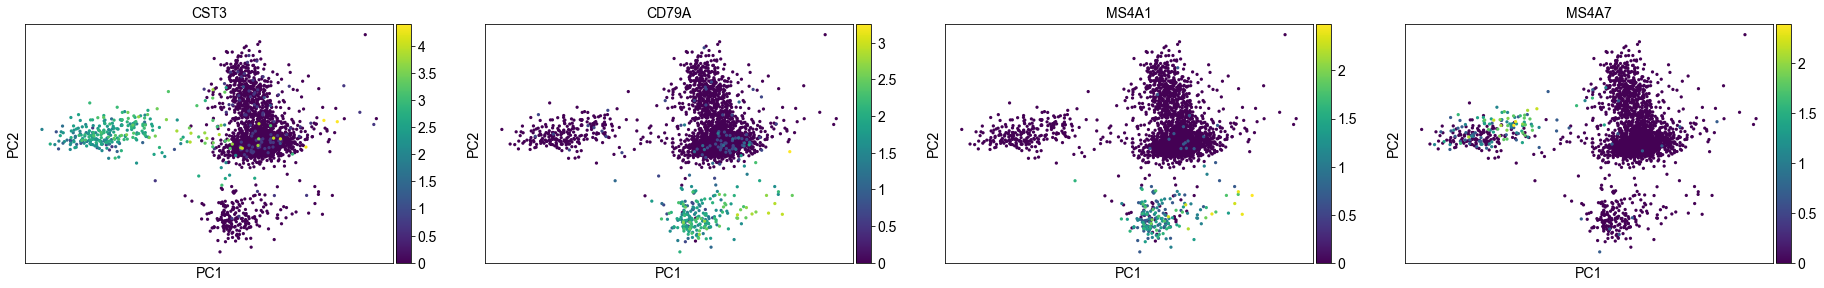

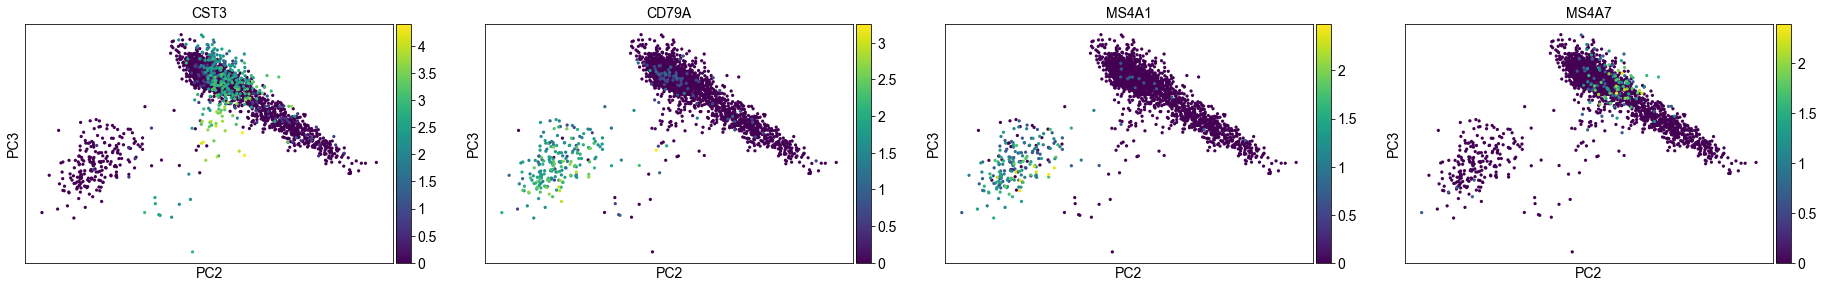

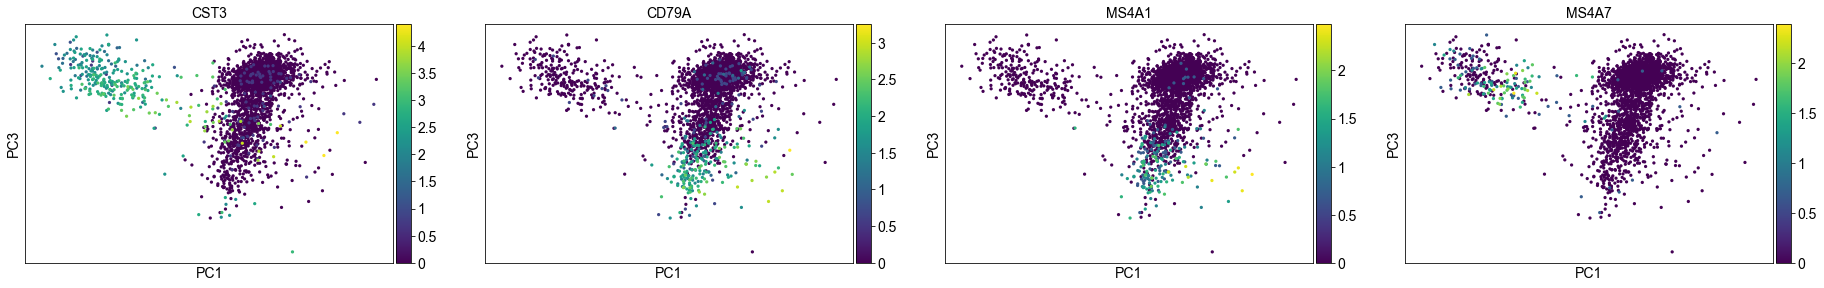

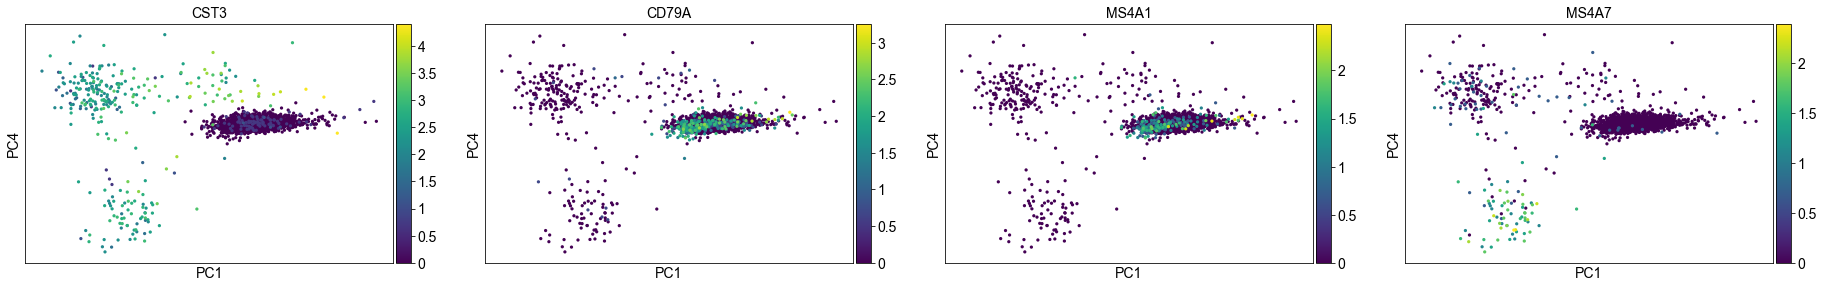

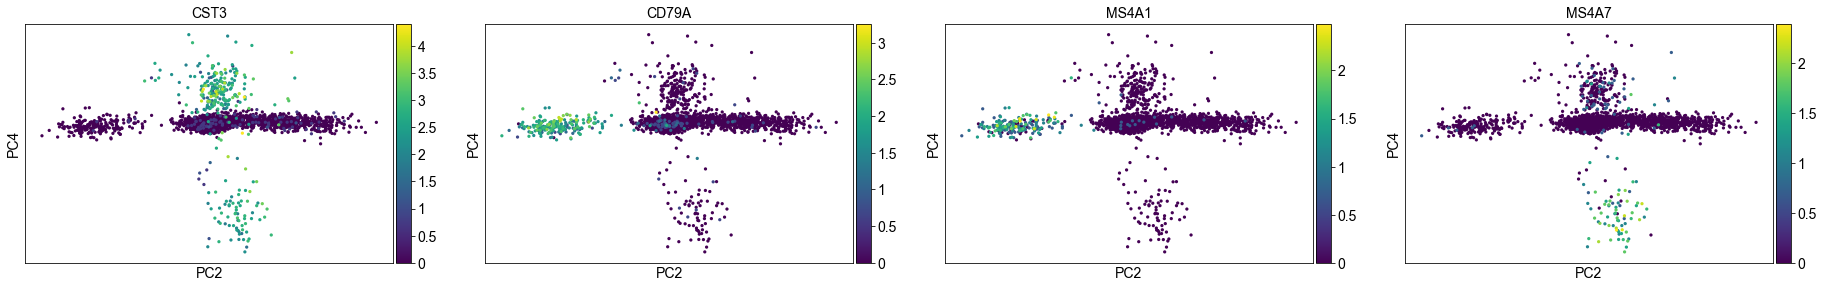

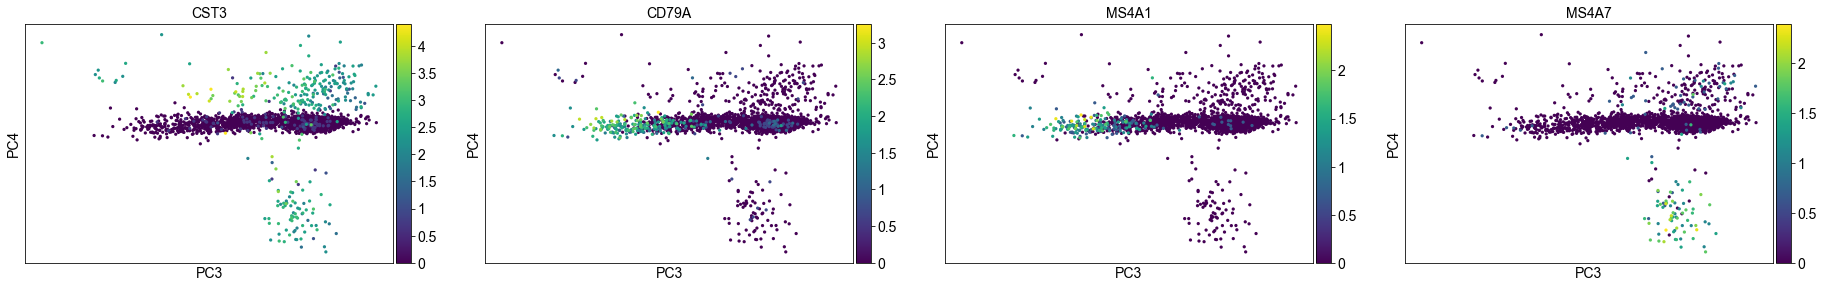

In [60]:
print (adata2.obsm['X_pca'].shape)
sc.pl.pca_scatter(adata2, color=['CST3','CD79A', 'MS4A1', 'MS4A7'])
sc.pl.pca_scatter(adata2, color=['CST3','CD79A', 'MS4A1', 'MS4A7'],components='2,3')
sc.pl.pca_scatter(adata2, color=['CST3','CD79A', 'MS4A1', 'MS4A7'],components='1,3')
sc.pl.pca_scatter(adata2, color=['CST3','CD79A', 'MS4A1', 'MS4A7'],components='1,4')
sc.pl.pca_scatter(adata2, color=['CST3','CD79A', 'MS4A1', 'MS4A7'],components='2,4')
sc.pl.pca_scatter(adata2, color=['CST3','CD79A', 'MS4A1', 'MS4A7'],components='3,4')

---------------------------

<font color=blue>Moreover, we can plot the gene ranks for the first four PCs as follows:</font>

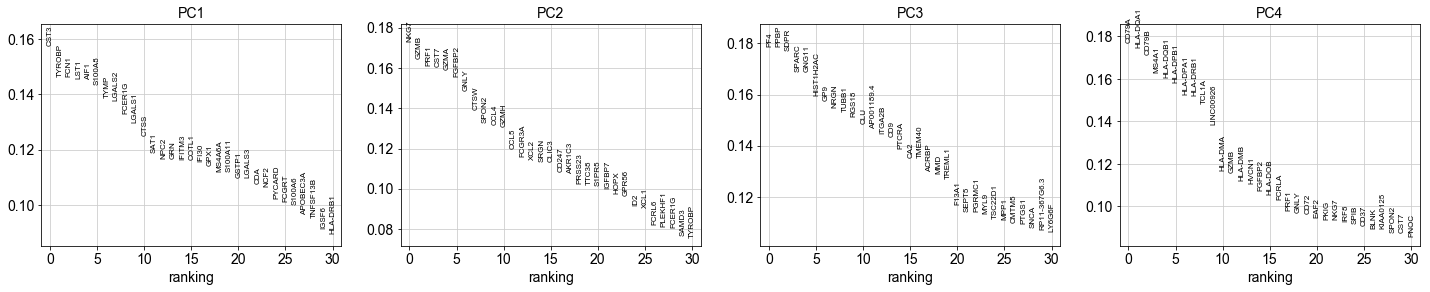

In [61]:
sc.pl.pca_loadings(adata, [1,2,3,4])

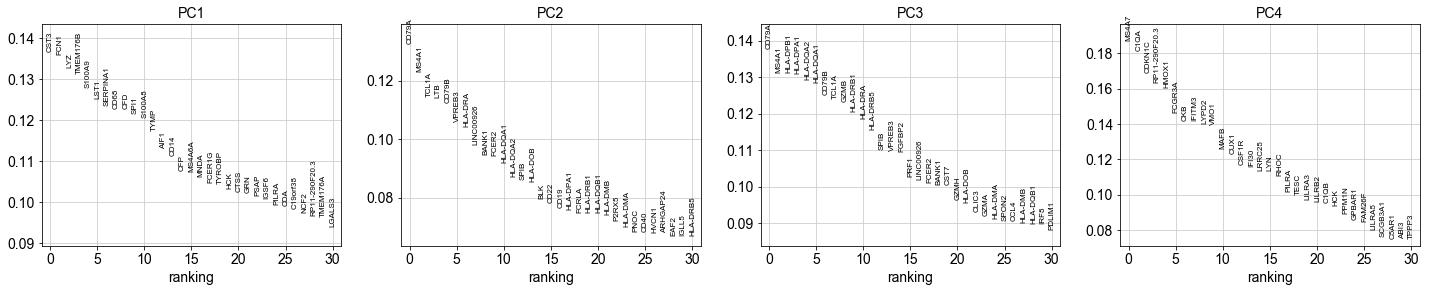

In [62]:
sc.pl.pca_loadings(adata2, [1,2,3,4])

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

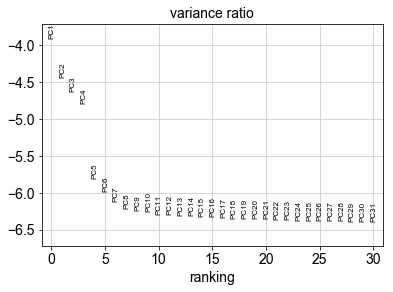

In [63]:
sc.pl.pca_variance_ratio(adata, log=True)

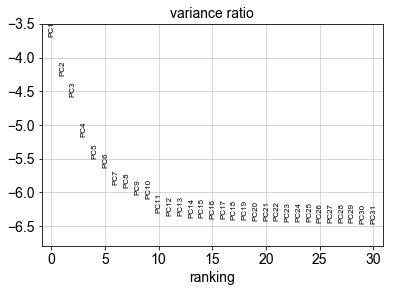

In [64]:
sc.pl.pca_variance_ratio(adata2, log=True)

<font color=red><B>General Observation:</B></font><br/><font color=blue>As we can see above, the variance ratio shows that the first four PCs in the first dataset contribute  -significantly- more to the total variance. On the same level, the first three PCs in the second dataset have more contribution than the rest.</font>

In [65]:
adata.write(results_file)

In [66]:
adata2.write(results_file2)

In [67]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [68]:
adata2

AnnData object with n_obs × n_vars = 2849 × 2142 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'var_ensemble', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## tSNE

We now advertise visualizing the data using UMAP, see below. In particular, if you have large data, this will give you a much faster first view of the data.

In [69]:
adata = sc.read(results_file)

In [70]:
adata2 = sc.read(results_file2)

In [71]:
#t-distributed stochastic neighborhood embedding (tSNE) 
#for visualizating single-cell data. 

#n_pcs : int or None, optional (default: None); Use this many PCs. 
#If n_pcs==0 use .X if use_rep is None.

#use_rep : {None, ‘X’} or any key for .obsm, optional (default: None)
#Use the indicated representation. 
#If None, the representation is chosen automatically: for .n_vars < 50, 
#.X is used, otherwise ‘X_pca’ is used. If ‘X_pca’ is not present, 
#it’s computed with default parameters.

#perplexity : float, optional (default: 30)
#The perplexity is related to the number of nearest neighbors that is used 
#in other manifold learning algorithms. 
#Larger datasets usually require a larger perplexity. 
#Consider selecting a value between 5 and 50. The choice is not extremely critical 
#since t-SNE is quite insensitive to this parameter.

#early_exaggeration : float, optional (default: 12.0)
#Controls how tight natural clusters in the original space are in the embedded space 
#and how much space will be between them. 
#For larger values, the space between natural clusters will be larger in the embedded space. 
#Again, the choice of this parameter is not very critical. 
#If the cost function increases during initial optimization, 
#the early exaggeration factor or the learning rate might be too high.

#learning_rate : float, optional (default: 1000)
#Note that the R-package “Rtsne” uses a default of 200. 
#The learning rate can be a critical parameter. 
#It should be between 100 and 1000. 
#If the cost function increases during initial optimization, 
#the early exaggeration factor or the learning rate might be too high. 
#If the cost function gets stuck in a bad local minimum increasing the learning 
#rate helps sometimes.

#random_state : int or None, optional (default: 0)
#Change this to use different intial states for the optimization. 
#If None, the initial state is not reproducible.

#use_fast_tsne : bool, optional (default: True)
#Use the MulticoreTSNE package by D. Ulyanov if it is installed.

#n_jobs : int or None (default: sc.settings.n_jobs)
#Number of jobs.

#copy : bool (default: False)
#Return a copy instead of writing to adata.
#and Return X_tsne (np.ndarray (adata.obs, dtype float)) 
#– tSNE coordinates of data.

sc.tl.tsne(adata, random_state=2, n_pcs=10)
adata.write(results_file)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:10.21) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [72]:
#t-distributed stochastic neighborhood embedding (tSNE) 
#for visualizating single-cell data. 

#n_pcs : int or None, optional (default: None); Use this many PCs. 
#If n_pcs==0 use .X if use_rep is None.

#use_rep : {None, ‘X’} or any key for .obsm, optional (default: None)
#Use the indicated representation. 
#If None, the representation is chosen automatically: for .n_vars < 50, 
#.X is used, otherwise ‘X_pca’ is used. If ‘X_pca’ is not present, 
#it’s computed with default parameters.

#perplexity : float, optional (default: 30)
#The perplexity is related to the number of nearest neighbors that is used 
#in other manifold learning algorithms. 
#Larger datasets usually require a larger perplexity. 
#Consider selecting a value between 5 and 50. The choice is not extremely critical 
#since t-SNE is quite insensitive to this parameter.

#early_exaggeration : float, optional (default: 12.0)
#Controls how tight natural clusters in the original space are in the embedded space 
#and how much space will be between them. 
#For larger values, the space between natural clusters will be larger in the embedded space. 
#Again, the choice of this parameter is not very critical. 
#If the cost function increases during initial optimization, 
#the early exaggeration factor or the learning rate might be too high.

#learning_rate : float, optional (default: 1000)
#Note that the R-package “Rtsne” uses a default of 200. 
#The learning rate can be a critical parameter. 
#It should be between 100 and 1000. 
#If the cost function increases during initial optimization, 
#the early exaggeration factor or the learning rate might be too high. 
#If the cost function gets stuck in a bad local minimum increasing the learning 
#rate helps sometimes.

#random_state : int or None, optional (default: 0)
#Change this to use different intial states for the optimization. 
#If None, the initial state is not reproducible.

#use_fast_tsne : bool, optional (default: True)
#Use the MulticoreTSNE package by D. Ulyanov if it is installed.

#n_jobs : int or None (default: sc.settings.n_jobs)
#Number of jobs.

#copy : bool (default: False)
#Return a copy instead of writing to adata.
#and Return X_tsne (np.ndarray (adata.obs, dtype float)) 
#– tSNE coordinates of data.

sc.tl.tsne(adata2, random_state=2, n_pcs=10)
adata2.write(results_file2)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:11.62) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [73]:
print(adata.obsm['X_tsne'].shape)
adata.obsm['X_tsne']

(2638, 2)


array([[ 14.89814409,  10.89610582],
       [ 44.03091177,  -7.64330011],
       [  2.53870636,  -2.44382385],
       ...,
       [ 37.58880552,   4.73509504],
       [ 40.8663854 ,   0.52811246],
       [-10.55988329,   6.68839217]])

In [74]:
print(adata2.obsm['X_tsne'].shape)
adata2.obsm['X_tsne']

(2849, 2)


array([[-42.40445802,   5.71951809],
       [ 29.5442833 , -24.43009912],
       [  8.80222904,  27.0893889 ],
       ...,
       [ 24.17117386,  14.28841433],
       [-37.97817432,   1.588216  ],
       [-32.6665889 ,  -3.48048182]])

---------------------------

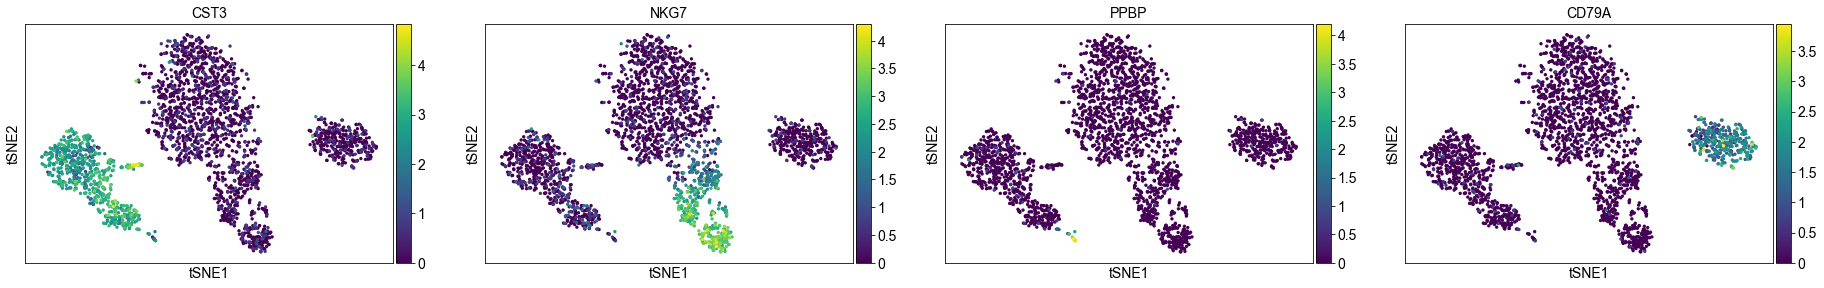

In [75]:
sc.pl.tsne(adata, color=['CST3','NKG7', 'PPBP', 'CD79A']) #, use_raw=True

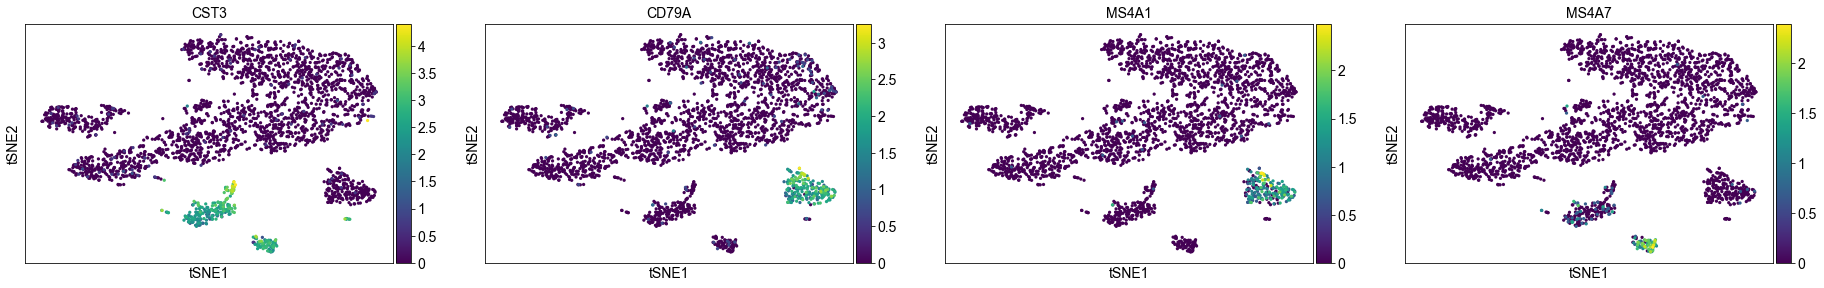

In [76]:
sc.pl.tsne(adata2, color=['CST3','CD79A', 'MS4A1','MS4A7']) #, use_raw=True

---------------------------

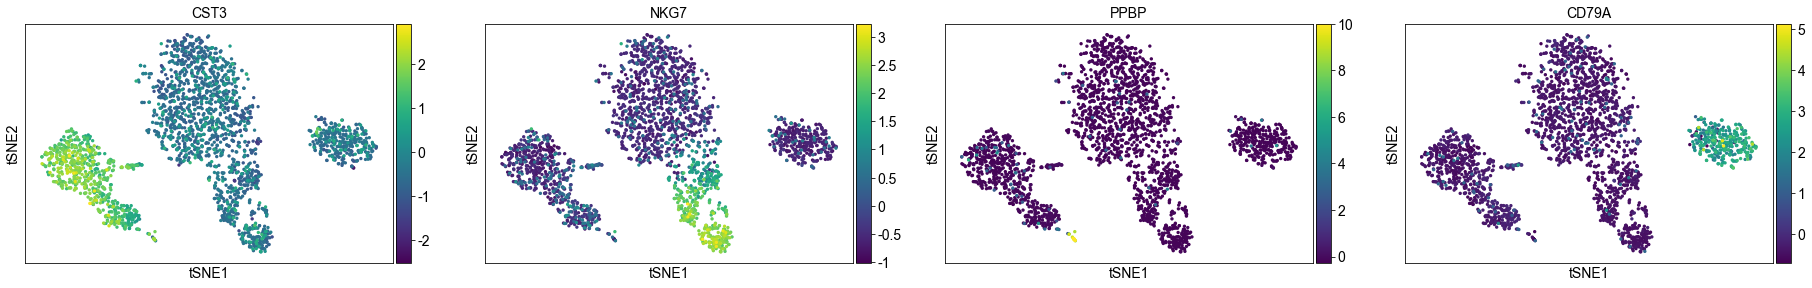

In [77]:
sc.pl.tsne(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'], show=True, use_raw=False)

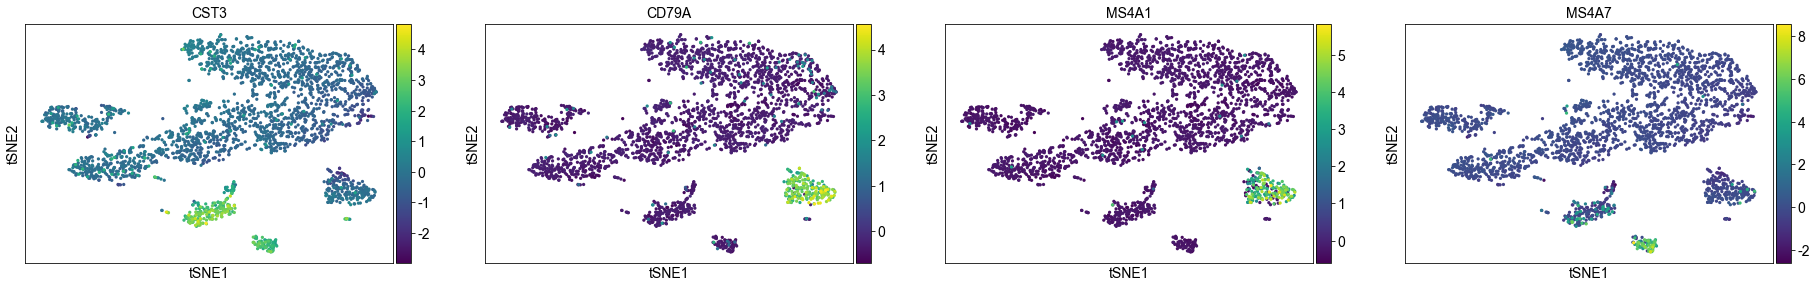

In [78]:
sc.pl.tsne(adata2, color=['CST3','CD79A', 'MS4A1','MS4A7'], use_raw=False)

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression.

## Computing the Neighborhood Graph

### Visualizing Neighborhood Graph Using UMAP

> "(Uniform Manifold Approximation and Projection) is a manifold learning technique for dimension reduction which is suitable for visualization of high-dimensional data. It is competitive with tSNE yet, it is faster and it arguably preserves more of the global structure." --scanpy.api.tl.umap

In [104]:
adata = sc.read(results_file)

In [105]:
adata2 = sc.read(results_file2)

In [106]:
#Compute a neighborhood graph of observations 

#n_neighbors : int
#The size of local neighborhood (in terms of number of neighboring data points) used 
#for manifold approximation. Larger values result in more global views of the 
#manifold, while smaller values result in more local data being preserved. 
#In general values should be in the range 2 to 100. If knn is True, number of nearest 
#neighbors to be searched. If knn is False, a Gaussian kernel width is set to the 
#distance of the n_neighbors neighbor.

#Return: 
#1)connectivities (sparse matrix (.uns[‘neighbors’], dtype float32)) – Weighted 
#adjacency matrix of the neighborhood graph of data points. 
#Weights should be interpreted as connectivities.
#2)distances (sparse matrix (.uns[‘neighbors’], dtype float32)) – Instead of 
#decaying weights, this stores distances for each pair of neighbors.
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00.27)
    computed connectivities (0:00:00.51)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [107]:
#Compute a neighborhood graph of observations 

#n_neighbors : int
#The size of local neighborhood (in terms of number of neighboring data points) used 
#for manifold approximation. Larger values result in more global views of the 
#manifold, while smaller values result in more local data being preserved. 
#In general values should be in the range 2 to 100. If knn is True, number of nearest 
#neighbors to be searched. If knn is False, a Gaussian kernel width is set to the 
#distance of the n_neighbors neighbor.

#Return: 
#1)connectivities (sparse matrix (.uns[‘neighbors’], dtype float32)) – Weighted 
#adjacency matrix of the neighborhood graph of data points. 
#Weights should be interpreted as connectivities.
#2)distances (sparse matrix (.uns[‘neighbors’], dtype float32)) – Instead of 
#decaying weights, this stores distances for each pair of neighbors.
sc.pp.neighbors(adata2, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00.26)
    computed connectivities (0:00:00.58)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Get a quick visualization of the graph using UMAP. For larger data, the speedup over tSNE will be dramatic.

In [108]:
#Embed the neighborhood graph using UMAP
#Return: X_umap (adata.obsm) – UMAP coordinates of data.
sc.tl.umap(adata)

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished (0:00:03.76) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [109]:
#Embed the neighborhood graph using UMAP
#Return: X_umap (adata.obsm) – UMAP coordinates of data.
sc.tl.umap(adata2)

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished (0:00:04.13) --> added
    'X_umap', UMAP coordinates (adata.obsm)


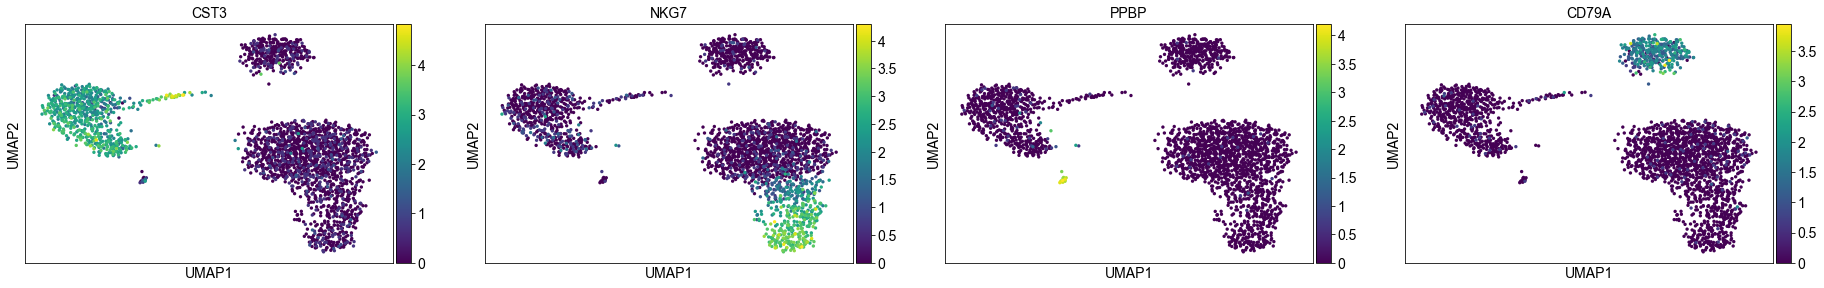

In [85]:
sc.pl.umap(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'])

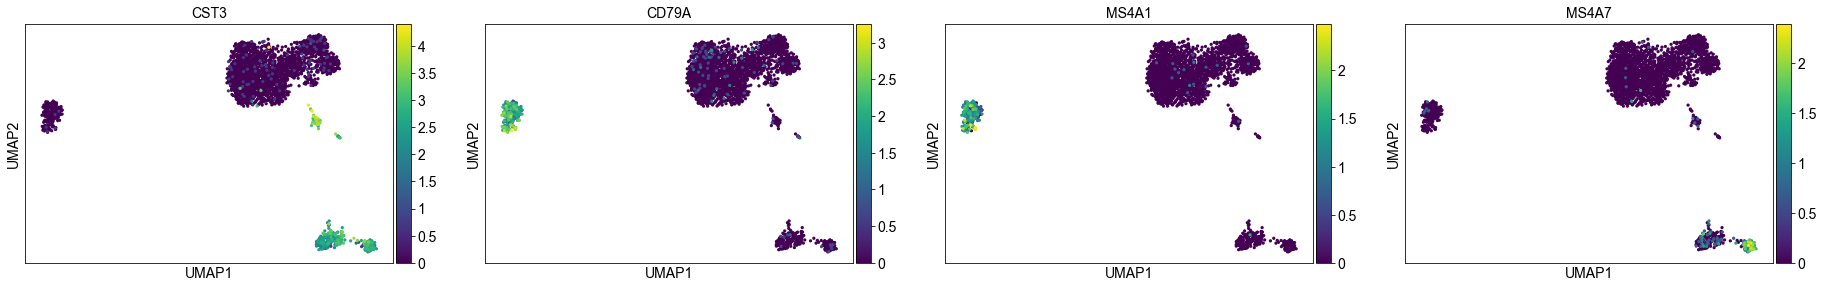

In [86]:
sc.pl.umap(adata2, color=['CST3','CD79A', 'MS4A1','MS4A7'])

Btw: You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

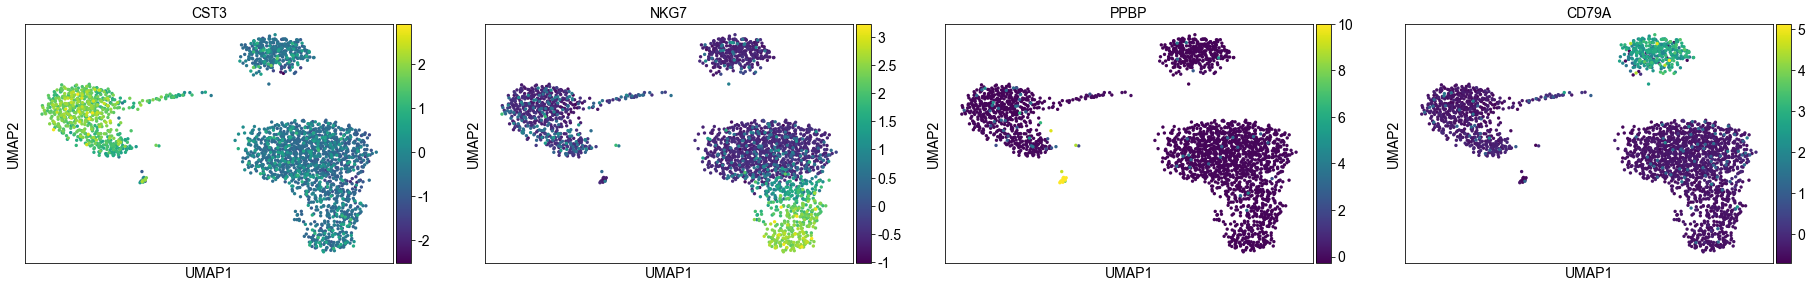

In [87]:
sc.pl.umap(adata, color=['CST3','NKG7', 'PPBP', 'CD79A'], use_raw=False)

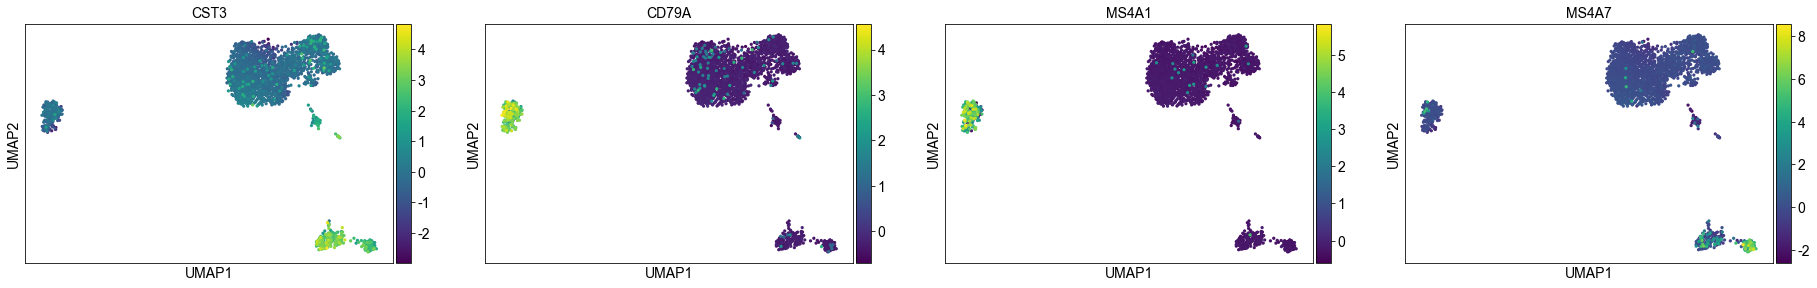

In [88]:
sc.pl.umap(adata2, color=['CST3','CD79A', 'MS4A1','MS4A7'], use_raw=False)

### Visualizing Neighborhood Graph Using T-SNE

In [89]:
adata = sc.read(results_file)

In [90]:
adata2 = sc.read(results_file2)

In [91]:
#Compute a neighborhood graph of observations 

#n_neighbors : int
#The size of local neighborhood (in terms of number of neighboring data points) used 
#for manifold approximation. Larger values result in more global views of the 
#manifold, while smaller values result in more local data being preserved. 
#In general values should be in the range 2 to 100. If knn is True, number of nearest 
#neighbors to be searched. If knn is False, a Gaussian kernel width is set to the 
#distance of the n_neighbors neighbor.

#Return: 
#1)connectivities (sparse matrix (.uns[‘neighbors’], dtype float32)) – Weighted 
#adjacency matrix of the neighborhood graph of data points. 
#Weights should be interpreted as connectivities.
#2)distances (sparse matrix (.uns[‘neighbors’], dtype float32)) – Instead of 
#decaying weights, this stores distances for each pair of neighbors.
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00.19)
    computed connectivities (0:00:00.46)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [92]:
#Compute a neighborhood graph of observations 

#n_neighbors : int
#The size of local neighborhood (in terms of number of neighboring data points) used 
#for manifold approximation. Larger values result in more global views of the 
#manifold, while smaller values result in more local data being preserved. 
#In general values should be in the range 2 to 100. If knn is True, number of nearest 
#neighbors to be searched. If knn is False, a Gaussian kernel width is set to the 
#distance of the n_neighbors neighbor.

#Return: 
#1)connectivities (sparse matrix (.uns[‘neighbors’], dtype float32)) – Weighted 
#adjacency matrix of the neighborhood graph of data points. 
#Weights should be interpreted as connectivities.
#2)distances (sparse matrix (.uns[‘neighbors’], dtype float32)) – Instead of 
#decaying weights, this stores distances for each pair of neighbors.
sc.pp.neighbors(adata2, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00.24)
    computed connectivities (0:00:00.48)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [93]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:10.70) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [94]:
sc.tl.tsne(adata2)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.81) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


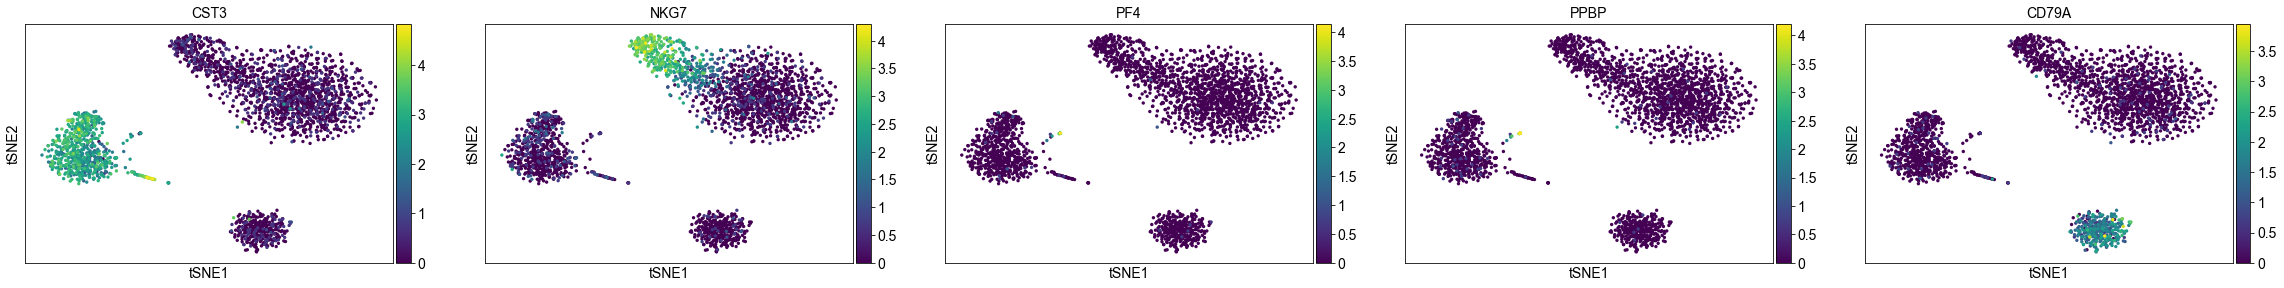

In [95]:
sc.pl.tsne(adata, color=['CST3','NKG7', 'PF4', 'PPBP', 'CD79A'])

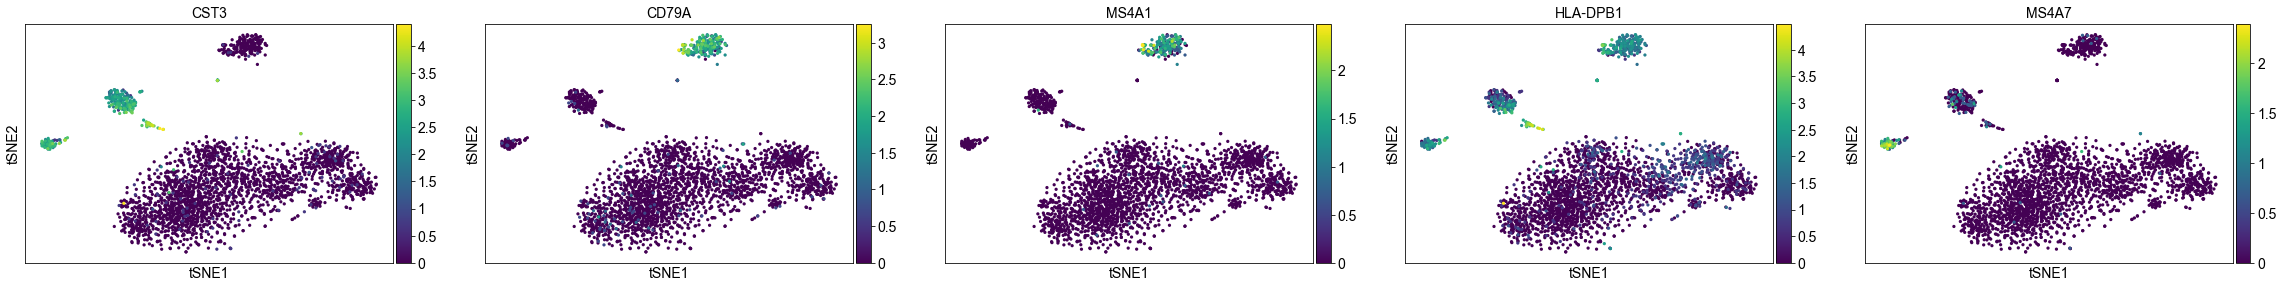

In [96]:
sc.pl.tsne(adata2, color=['CST3','CD79A', 'MS4A1', 'HLA-DPB1','MS4A7'])

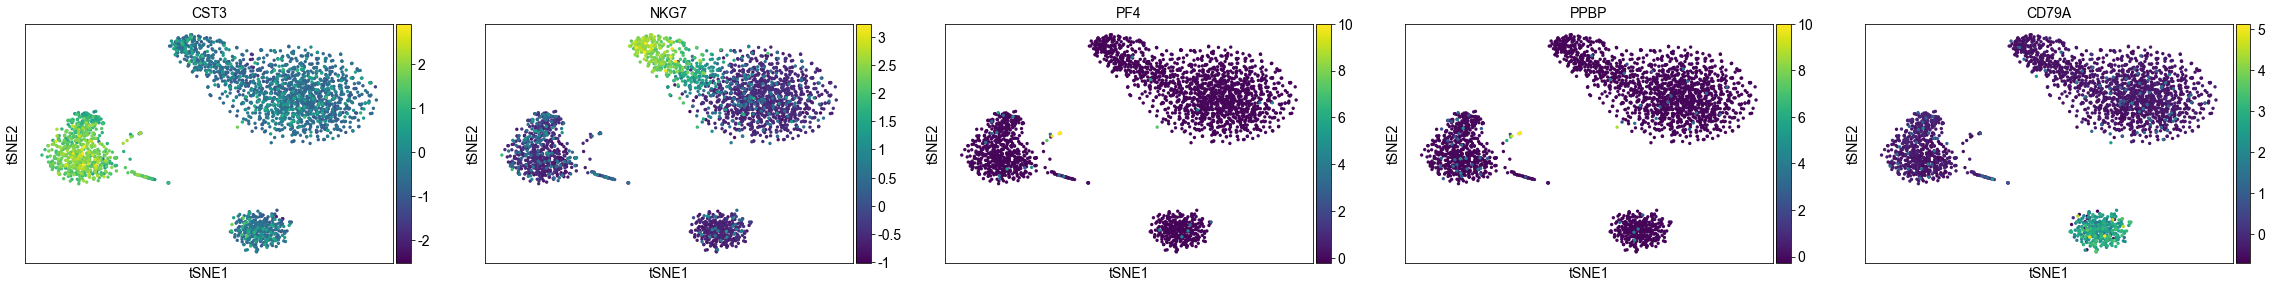

In [97]:
sc.pl.tsne(adata, color=['CST3','NKG7', 'PF4', 'PPBP', 'CD79A'], use_raw=False)

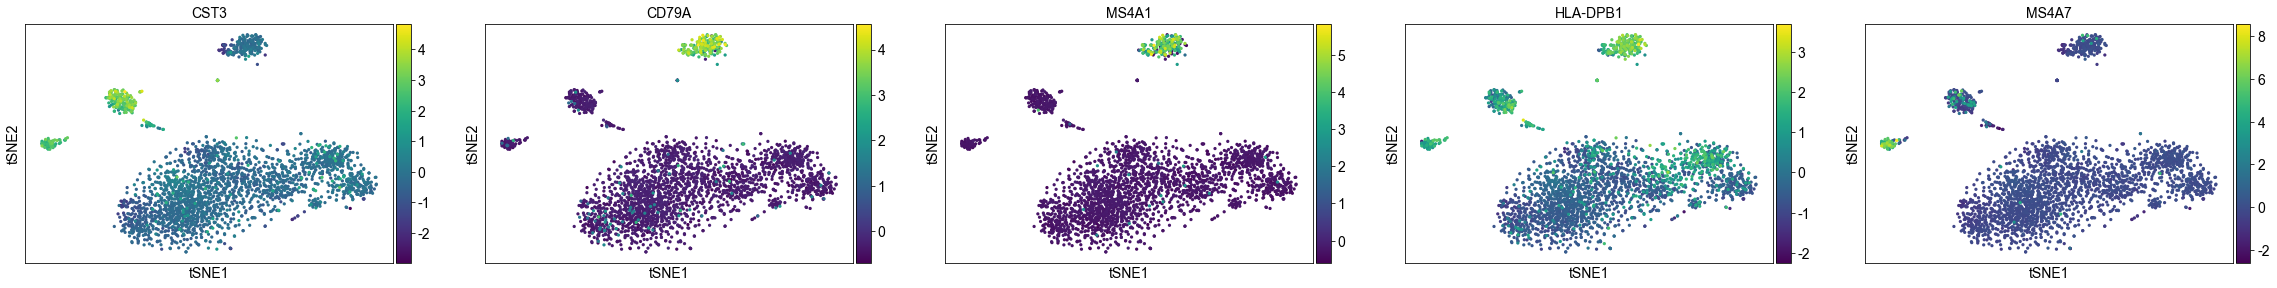

In [98]:
sc.pl.tsne(adata2, color=['CST3','CD79A', 'MS4A1', 'HLA-DPB1','MS4A7'], use_raw=False)

## Clustering the Neighboring Graph --from tsne & umap

As Seurat and many others, we use the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.04).

In order to run Louvain clustering, we first need to compute the neighborhood graph of cells - we already did this in the previous section.

In [111]:
#Cluster cells into subgroups
#This requires to run neighbors(), first.

#n_neighbors:int, optional (default: 30),
#Number of neighbors to use for construction of knn graph.
#n_pcs:int, optional (default: 50)

#Return: louvain :pandas.Series (adata.obs, dtype category)
#Array of dim (number of samples) that stores the subgroup id (‘0’, ‘1’, …) 
#for each cell.
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.17) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [112]:
#Cluster cells into subgroups
#This requires to run neighbors(), first.

#n_neighbors:int, optional (default: 30),
#Number of neighbors to use for construction of knn graph.
#n_pcs:int, optional (default: 50)

#Return: louvain :pandas.Series (adata.obs, dtype category)
#Array of dim (number of samples) that stores the subgroup id (‘0’, ‘1’, …) 
#for each cell.
sc.tl.louvain(adata2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.26) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


### Visualizing Clusters Using T-SNE

Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

    generating colors for louvain using palette


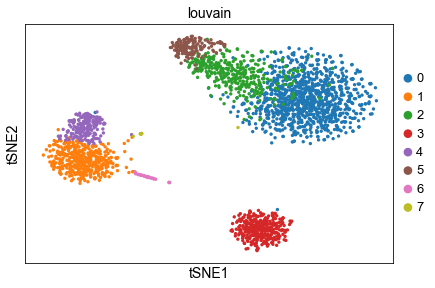

In [101]:
sc.pl.tsne(adata, color='louvain')
#adata.obs[['louvain']]

    generating colors for louvain using palette


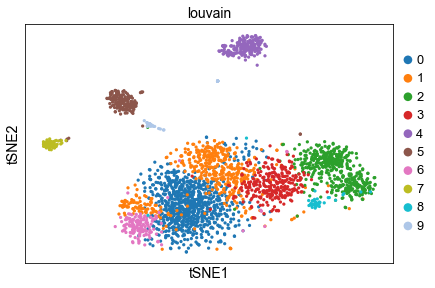

In [102]:
sc.pl.tsne(adata2, color='louvain')
#adata2.obs[['louvain']]

### Visualizing Clusters Using UMAP

    generating colors for louvain using palette


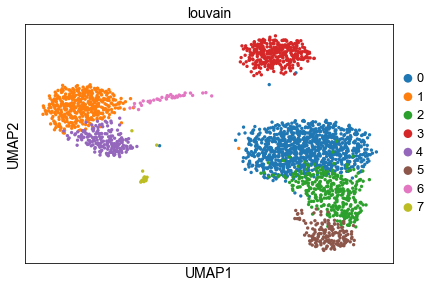

In [113]:
sc.pl.umap(adata, color='louvain')

    generating colors for louvain using palette


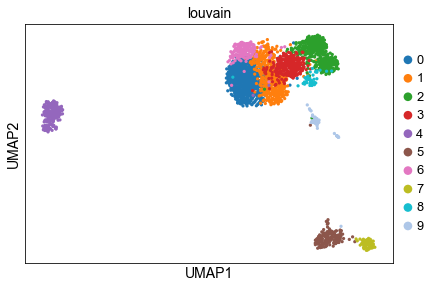

In [114]:
sc.pl.umap(adata2, color='louvain')

In [115]:
adata.write(results_file)

In [116]:
adata2.write(results_file2)

## Finding marker genes

Let us compute a ranking for <B>the highly differential genes in each cluster</B>. Here, we simply rank genes with a <B>t-test</B>, which agrees quite well with Seurat.

For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before.

ranking genes
    consider 'louvain' groups: ['0' '1' '2' '3' '4' '5' '6' '7']
    with sizes: [1094  439  362  341  190  159   38   15]
    finished (0:00:00.84) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


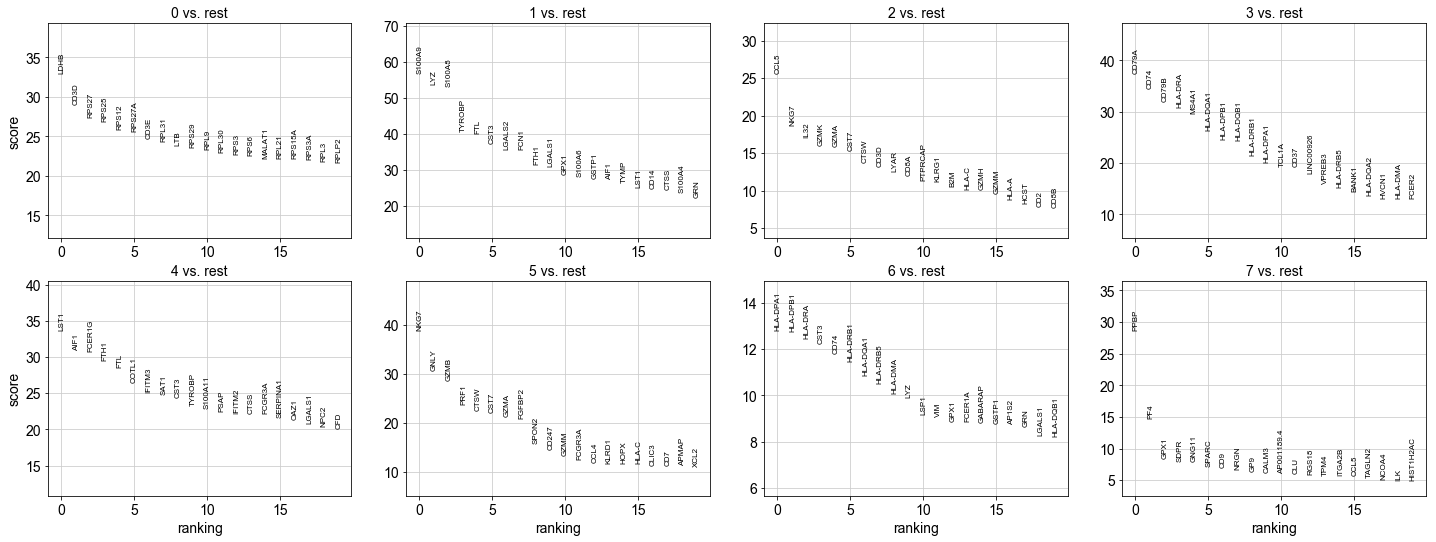

In [117]:
adata = sc.read(results_file)

#Rank genes for characterizing groups
#groupby : str; The key of the observations grouping to consider.
#method : {'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'}, optional (default: 't-test_overestim_var')
#Return:
#Updates adata with the following fields.
#names (structured np.ndarray (.uns[‘rank_genes_groups’])) – Structured array to be indexed by group id storing 
#the gene names. Ordered according to scores.
#scores (structured np.ndarray (.uns[‘rank_genes_groups’])) – Structured array to be indexed by group id storing 
#the score for each gene for each group. Ordered according to scores.
sc.tl.rank_genes_groups(adata, 'louvain')

#Plot ranking of genes for all tested comparisons
#n_genes : int, optional (default: 20); Number of genes to show. Is ignored if gene_names is passed.
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
adata.write(results_file)

ranking genes
    consider 'louvain' groups: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
    with sizes: [867 510 473 302 211 179 149  75  42  41]
    finished (0:00:01.22) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


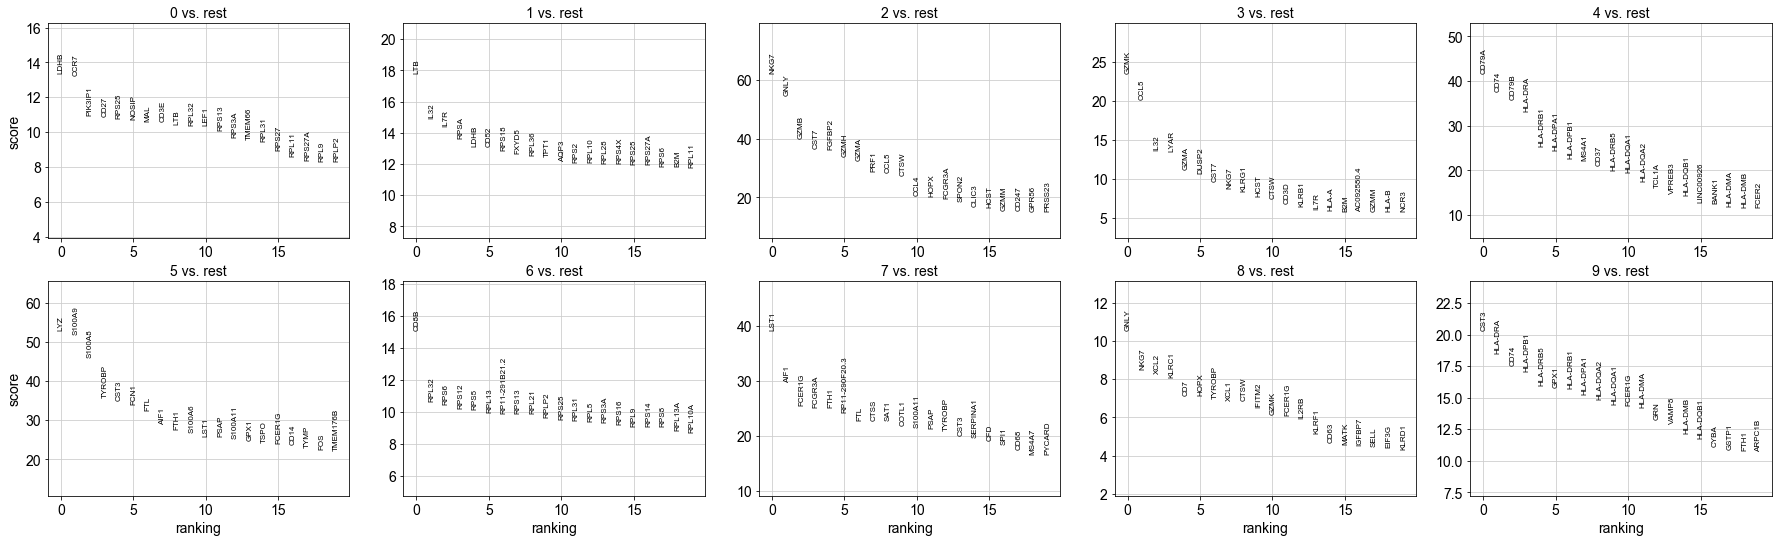

In [118]:
adata2 = sc.read(results_file2)

#Rank genes for characterizing groups
#groupby : str; The key of the observations grouping to consider.
#method : {'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'}, optional (default: 't-test_overestim_var')
#Return:
#Updates adata with the following fields.
#names (structured np.ndarray (.uns[‘rank_genes_groups’])) – Structured array to be indexed by group id storing 
#the gene names. Ordered according to scores.
#scores (structured np.ndarray (.uns[‘rank_genes_groups’])) – Structured array to be indexed by group id storing 
#the score for each gene for each group. Ordered according to scores.
sc.tl.rank_genes_groups(adata2, 'louvain')

#Plot ranking of genes for all tested comparisons
#n_genes : int, optional (default: 20); Number of genes to show. Is ignored if gene_names is passed.
sc.pl.rank_genes_groups(adata2, n_genes=20, save='.pdf')
adata2.write(results_file2)

In [119]:
sc.settings.verbosity = 2  # reduce the verbosity to no longer see hints

Here, we rank genes using logistic regression. For instance, this has been suggested by [Natranos *et al.* (2018)](https://doi.org/10.1101/258566). We think that this works very well. Here, it recovers known marker genes at higer rankings than using a t-test or Wilcoxon rank sum test.

ranking genes
    finished (0:00:03.68)


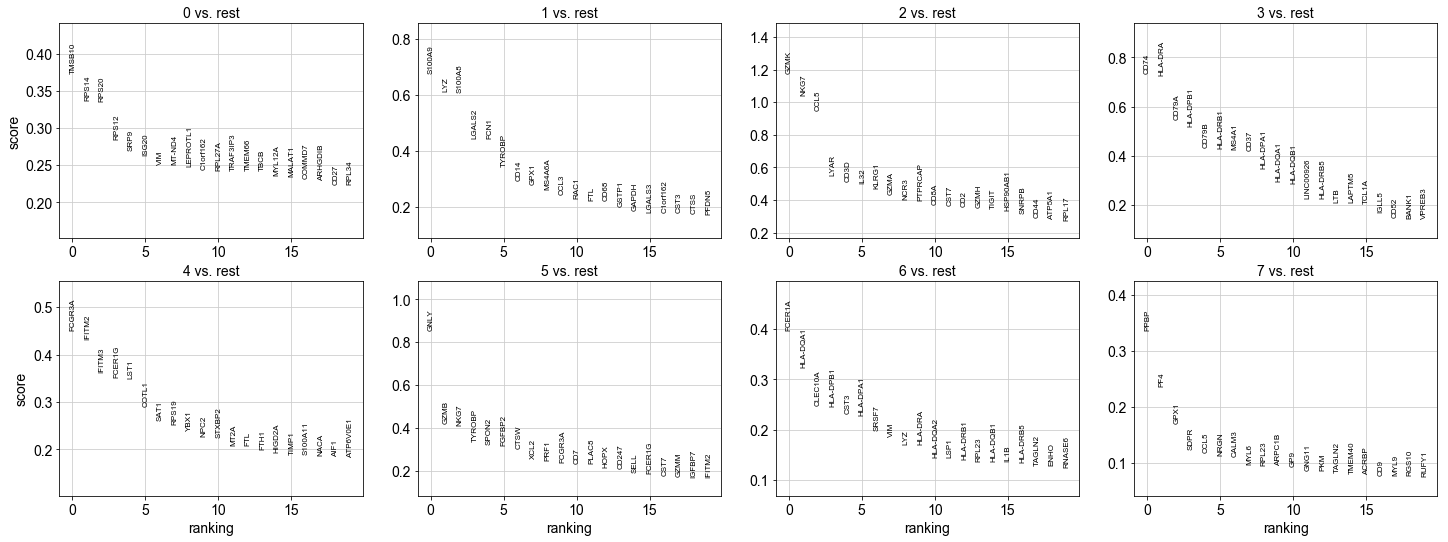

In [120]:
#method : {'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'}, optional (default: 't-test_overestim_var')
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20)

ranking genes
    finished (0:00:04.71)


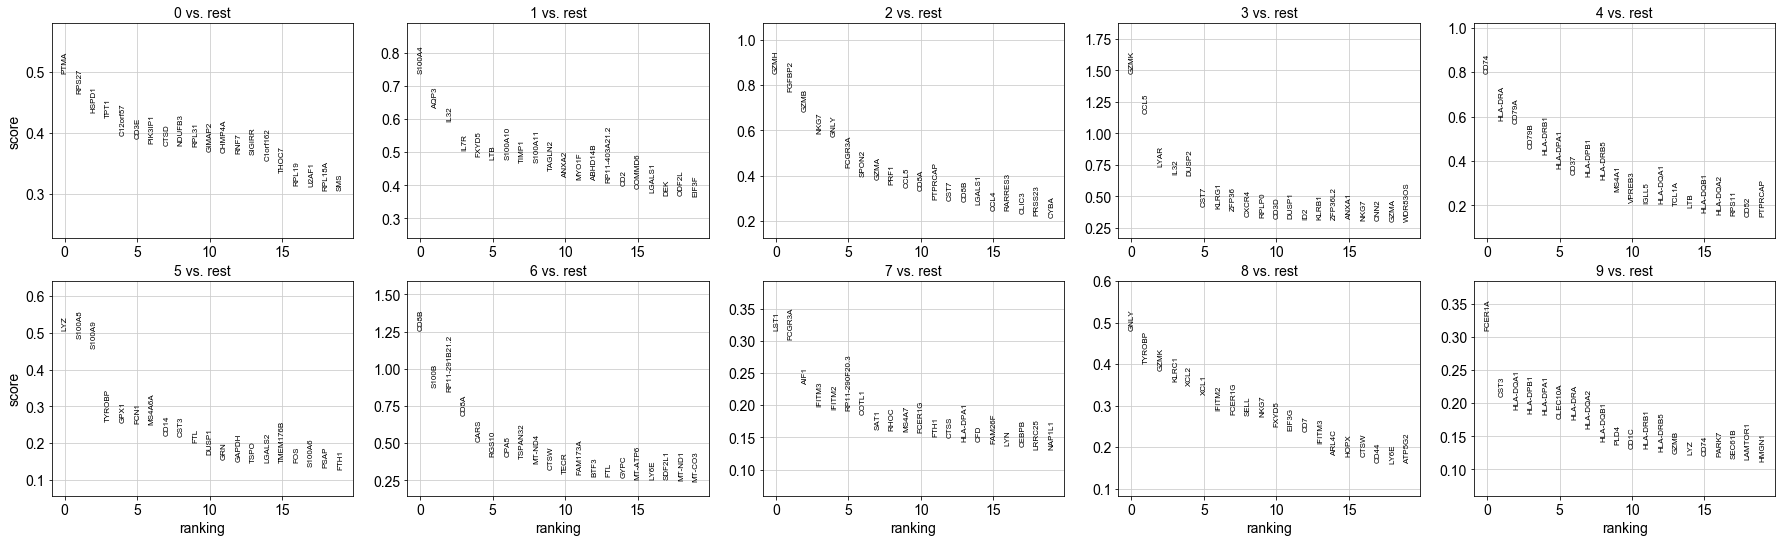

In [121]:
#method : {'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'}, optional (default: 't-test_overestim_var')
sc.tl.rank_genes_groups(adata2, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata2, n_genes=20)

---------------------------

With the exception of IL7R, which is only found by the t-test at rank 14, all marker genes are recovered.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	GNLY, NKG7 | 	NK cells
5 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes


Louvain Group | Markers | Cell Type
---|---|---
0 | CD3E | CD3 T cells
1 | IL7R | CD4 T cells
2 | NKG7,GNLY,GZMB | Erythroblasts (mixture of natural killer cells and CD8+ T cells)
3 |	NKG7, CD3D | NK cells ?? CD3 T cells
4 |	CD79A, CD79B, MS4A1 | B cells
5 |	LYZ, CD14 |	CD14+CD16 Monocytes
6 |	CD8B, CD8A | CD8 T cells
7 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
8 |	GNLY,NKG7 |	NK cells
9 |	FCER1A, CST3 | Dendritic cells

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [123]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0       1        2         3       4       5         6       7
0    TMSB10  S100A9     GZMK      CD74  FCGR3A    GNLY    FCER1A    PPBP
1     RPS14     LYZ     NKG7   HLA-DRA  IFITM2    GZMB  HLA-DQA1     PF4
2     RPS20  S100A8     CCL5     CD79A  IFITM3    NKG7   CLEC10A    GPX1
3     RPS12  LGALS2     LYAR  HLA-DPB1  FCER1G  TYROBP  HLA-DPB1    SDPR
4      SRP9    FCN1     CD3D     CD79B    LST1   SPON2      CST3    CCL5
5     ISG20  TYROBP     IL32  HLA-DRB1   COTL1  FGFBP2  HLA-DPA1    NRGN
6       VIM    CD14    KLRG1     MS4A1    SAT1    CTSW     SRSF7   CALM3
7    MT-ND4    GPX1     GZMA      CD37   RPS19    XCL2       VIM    MYL6
8  LEPROTL1  MS4A6A     NCR3  HLA-DPA1    YBX1    PRF1       LYZ   RPL23
9  C1orf162    CCL3  PTPRCAP  HLA-DQA1    NPC2  FCGR3A   HLA-DRA  ARPC1B

In [122]:
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(10)

0        1       2      3         4       5              6  \
0      PTMA   S100A4    GZMH   GZMK      CD74     LYZ           CD8B   
1     RPS27     AQP3  FGFBP2   CCL5   HLA-DRA  S100A8          S100B   
2     HSPD1     IL32    GZMB   LYAR     CD79A  S100A9  RP11-291B21.2   
3      TPT1     IL7R    NKG7   IL32     CD79B  TYROBP           CD8A   
4  C12orf57    FXYD5    GNLY  DUSP2  HLA-DRB1    GPX1           CARS   
5      CD3E      LTB  FCGR3A   CST7  HLA-DPA1    FCN1          RGS10   
6   PIK3IP1  S100A10   SPON2  KLRG1      CD37  MS4A6A           CPA5   
7      CTSD    TIMP1    GZMA  ZFP36  HLA-DPB1    CD14        TSPAN32   
8    NDUFB3  S100A11    PRF1  CXCR4  HLA-DRB5    CST3         MT-ND4   
9     RPL31   TAGLN2    CCL5  RPLP0     MS4A1     FTL           CTSW   

               7       8         9  
0           LST1    GNLY    FCER1A  
1         FCGR3A  TYROBP      CST3  
2           AIF1    GZMK  HLA-DQA1  
3         IFITM3   KLRC1  HLA-DPB1  
4         IFITM2    XCL2  HLA-DPA1  
5  RP11-290F20.3    XCL1   CLEC10A  
6          COTL1  IFITM2   HLA-DRA  
7           SAT1  FCER1G  HLA-DQA2  
8           RHOC    SELL  HLA-DQB1  
9          MS4A7    NKG7      PLD4

<B><font color=red>---------------------------------------- For testing purposes! Don't run! ------------------------------------------</font></B>
<br/>If you would like to look up a gene in the dataframe above, run the following:

In [ ]:
g='CD3D'
#-------------------------------------------
test_df=pd.DataFrame()
test_df.insert(loc=0, column='Rank', value=list(np.where(pd.DataFrame(adata.uns['rank_genes_groups']['names']) == g)[0]), allow_duplicates=True)
test_df.insert(loc=1, column='Cluster#', value=list(np.where(pd.DataFrame(adata.uns['rank_genes_groups']['names']) == g)[1]), allow_duplicates=True)
test_df

In [ ]:
g2='CST3'
#-------------------------------------------
test2_df=pd.DataFrame()
test2_df.insert(loc=0, column='Rank', value=list(np.where(pd.DataFrame(adata2.uns['rank_genes_groups']['names']) == g2)[0]), allow_duplicates=True)
test2_df.insert(loc=1, column='Cluster#', value=list(np.where(pd.DataFrame(adata2.uns['rank_genes_groups']['names']) == g2)[1]), allow_duplicates=True)
test2_df

<B><font color=red>-----------------------------------------------------------------------------------------------------------------------------</font></B>

Get a table with scores and groups.

In [124]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(10)

0_n       0_s     1_n       1_s      2_n       2_s       3_n  \
0    TMSB10  0.374223  S100A9  0.677477     GZMK  1.178449      CD74   
1     RPS14  0.337569     LYZ  0.612554     NKG7  1.039310   HLA-DRA   
2     RPS20  0.336040  S100A8  0.609546     CCL5  0.947564     CD79A   
3     RPS12  0.284643  LGALS2  0.443715     LYAR  0.550416  HLA-DPB1   
4      SRP9  0.269665    FCN1  0.443459     CD3D  0.515459     CD79B   
5     ISG20  0.263415  TYROBP  0.344389     IL32  0.505147  HLA-DRB1   
6       VIM  0.251945    CD14  0.295841    KLRG1  0.474152     MS4A1   
7    MT-ND4  0.251101    GPX1  0.280205     GZMA  0.436621      CD37   
8  LEPROTL1  0.248867  MS4A6A  0.263970     NCR3  0.402351  HLA-DPA1   
9  C1orf162  0.244930    CCL3  0.243300  PTPRCAP  0.398563  HLA-DQA1   

        3_s     4_n       4_s     5_n       5_s       6_n       6_s     7_n  \
0  0.736510  FCGR3A  0.450452    GNLY  0.854029    FCER1A  0.396968    PPBP   
1  0.728774  IFITM2  0.431443    GZMB  0.423014  HLA-DQA1  0.323740     PF4   
2  0.548251  IFITM3  0.362420    NKG7  0.412747   CLEC10A  0.249507    GPX1   
3  0.520334  FCER1G  0.353047  TYROBP  0.336117  HLA-DPB1  0.246382    SDPR   
4  0.434905    LST1  0.349835   SPON2  0.322691      CST3  0.233178    CCL5   
5  0.428080   COTL1  0.290609  FGFBP2  0.321098  HLA-DPA1  0.228168    NRGN   
6  0.425612    SAT1  0.260590    CTSW  0.307426     SRSF7  0.198658   CALM3   
7  0.420196   RPS19  0.252968    XCL2  0.258708       VIM  0.187212    MYL6   
8  0.347920    YBX1  0.240017    PRF1  0.250261       LYZ  0.171794   RPL23   
9  0.295149    NPC2  0.228037  FCGR3A  0.240748   HLA-DRA  0.171642  ARPC1B   

        7_s  
0  0.335548  
1  0.235685  
2  0.171085  
3  0.123983  
4  0.119158  
5  0.113463  
6  0.110820  
7  0.097778  
8  0.095920  
9  0.095666

In [125]:
result2 = adata2.uns['rank_genes_groups']
groups2 = result2['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result2[key][group]
    for group in groups2 for key in ['names', 'scores']}).head(10)

0_n       0_s      1_n       1_s     2_n       2_s    3_n       3_s  \
0      PTMA  0.498369   S100A4  0.739157    GZMH  0.853705   GZMK  1.479377   
1     RPS27  0.465606     AQP3  0.631914  FGFBP2  0.772455   CCL5  1.162074   
2     HSPD1  0.434141     IL32  0.592484    GZMB  0.684425   LYAR  0.738470   
3      TPT1  0.425312     IL7R  0.507059    NKG7  0.587665   IL32  0.678915   
4  C12orf57  0.395738    FXYD5  0.488843    GNLY  0.572459  DUSP2  0.665436   
5      CD3E  0.390218      LTB  0.479748  FCGR3A  0.438723   CST7  0.422127   
6   PIK3IP1  0.382871  S100A10  0.478877   SPON2  0.398207  KLRG1  0.403823   
7      CTSD  0.379217    TIMP1  0.469378    GZMA  0.383806  ZFP36  0.386618   
8    NDUFB3  0.378905  S100A11  0.468349    PRF1  0.360716  CXCR4  0.342521   
9     RPL31  0.377183   TAGLN2  0.445916    CCL5  0.347724  RPLP0  0.333910   

        4_n       4_s     5_n       5_s            6_n       6_s  \
0      CD74  0.796615     LYZ  0.505687           CD8B  1.256842   
1   HLA-DRA  0.583829  S100A8  0.484082          S100B  0.873595   
2     CD79A  0.568467  S100A9  0.456723  RP11-291B21.2  0.847715   
3     CD79B  0.456226  TYROBP  0.258587           CD8A  0.686538   
4  HLA-DRB1  0.432224    GPX1  0.256147           CARS  0.510852   
5  HLA-DPA1  0.365271    FCN1  0.252900          RGS10  0.413573   
6      CD37  0.341787  MS4A6A  0.252268           CPA5  0.413358   
7  HLA-DPB1  0.330770    CD14  0.221999        TSPAN32  0.401643   
8  HLA-DRB5  0.319217    CST3  0.218819         MT-ND4  0.363134   
9     MS4A1  0.264170     FTL  0.202456           CTSW  0.324817   

             7_n       7_s     8_n       8_s       9_n       9_s  
0           LST1  0.315661    GNLY  0.480880    FCER1A  0.309491  
1         FCGR3A  0.302618  TYROBP  0.401159      CST3  0.210257  
2           AIF1  0.231889    GZMK  0.385551  HLA-DQA1  0.190624  
3         IFITM3  0.197831   KLRC1  0.359512  HLA-DPB1  0.184888  
4         IFITM2  0.194393    XCL2  0.349753  HLA-DPA1  0.182957  
5  RP11-290F20.3  0.192229    XCL1  0.328797   CLEC10A  0.177923  
6          COTL1  0.185760  IFITM2  0.288733   HLA-DRA  0.175461  
7           SAT1  0.162556  FCER1G  0.279403  HLA-DQA2  0.162538  
8           RHOC  0.160703    SELL  0.277203  HLA-DQB1  0.142929  
9          MS4A7  0.159245    NKG7  0.274348      PLD4  0.138707

Compare to a single cluster. 

ranking genes
    finished (0:00:00.09)


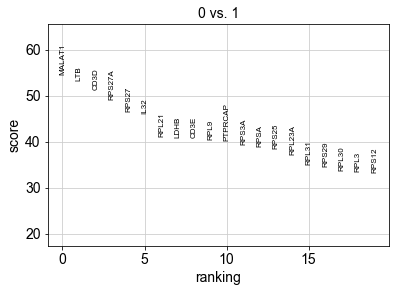

In [126]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

ranking genes
    finished (0:00:00.07)


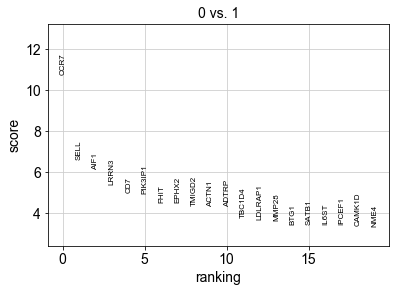

In [127]:
adata2 = sc.read(results_file2)
sc.tl.rank_genes_groups(adata2, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata2, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

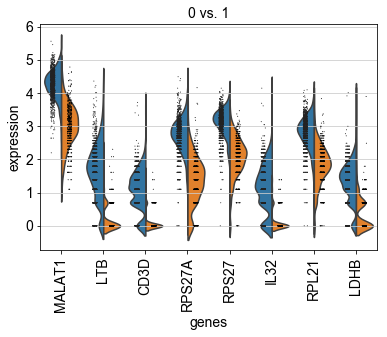

In [128]:
#Plot ranking of genes for all tested comparisons.
#groups : list of str, optional (default: None); List of group names.
#n_genes : int, optional (default: 20); Number of genes to show. Is ignored if gene_names is passed.
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

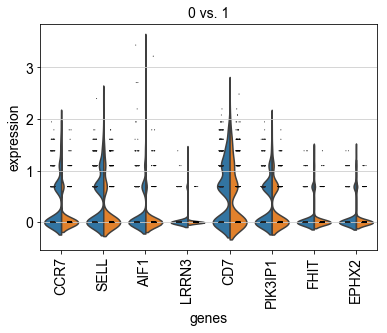

In [129]:
#Plot ranking of genes for all tested comparisons.
#groups : list of str, optional (default: None); List of group names.
#n_genes : int, optional (default: 20); Number of genes to show. Is ignored if gene_names is passed.
sc.pl.rank_genes_groups_violin(adata2, groups='0', n_genes=8)

Reread the examples that were computed by comparing to the rest of the groups.

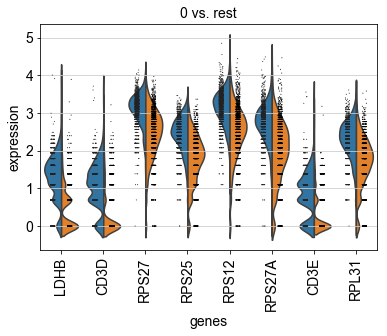

In [130]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

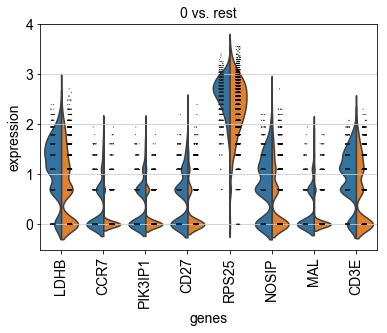

In [131]:
adata2 = sc.read(results_file2)
sc.pl.rank_genes_groups_violin(adata2, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

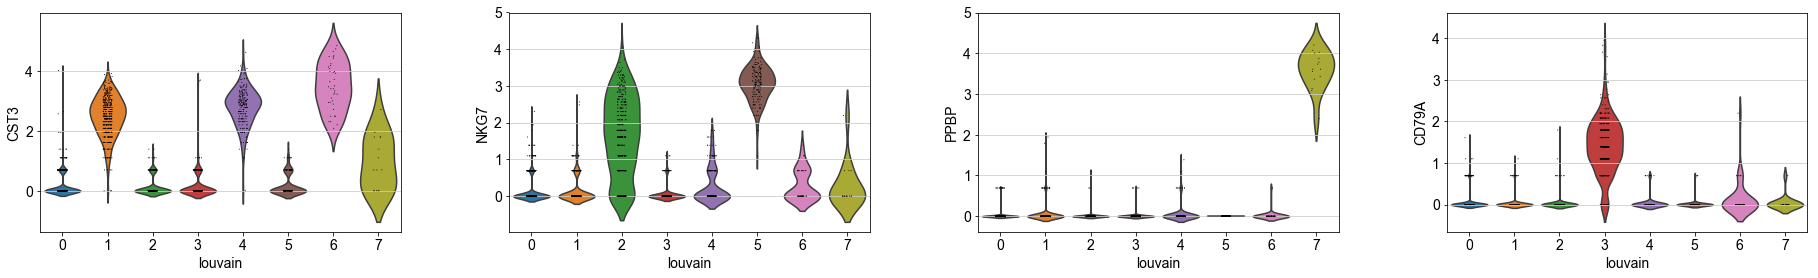

In [132]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP', 'CD79A'], groupby='louvain')

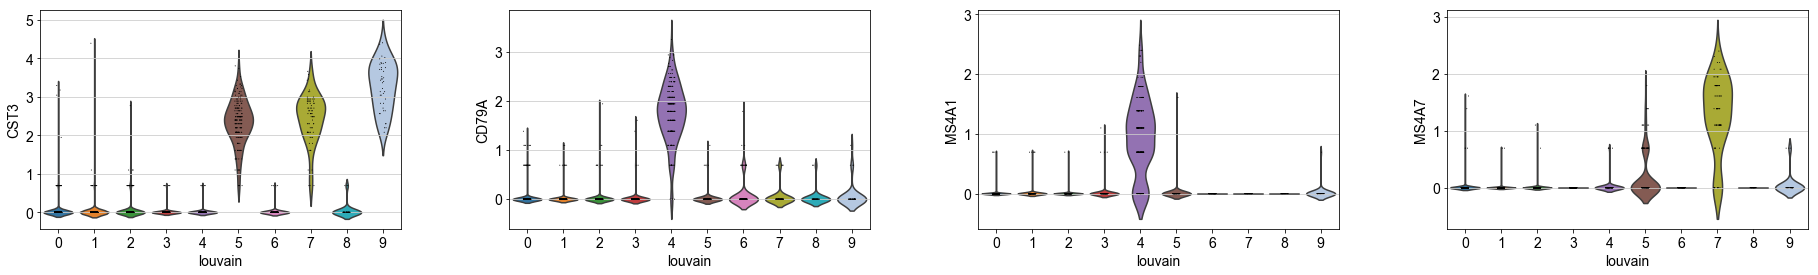

In [133]:
sc.pl.violin(adata2, ['CST3','CD79A', 'MS4A1', 'MS4A7'], groupby='louvain')

Actually mark the cell types.

In [134]:
new_cluster_names = [
    'CD4 T cells', 'CD14+ Monocytes',
    'B cells', 'CD8 T cells', 
    'NK cells', 'FCGR3A+ Monocytes',
    'Dendritic cells', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

In [135]:
new_cluster_names2 = [
    'CD3 T cells', 'CD4 T cells', 
    'Erythroblasts', 'NK cells ?? CD3 T cells', 
    'B cells', 'CD14+CD16 Monocytes', 
    'CD8 T cells', 'FCGR3A+ Monocytes', 
    'NK cells', 'Dendritic cells']
adata2.rename_categories('louvain', new_cluster_names2)

In [136]:
adata.uns['rank_genes_groups']['names'].dtype


dtype([('CD4 T cells', '<U50'), ('CD14+ Monocytes', '<U50'), ('B cells', '<U50'), ('CD8 T cells', '<U50'), ('NK cells', '<U50'), ('FCGR3A+ Monocytes', '<U50'), ('Dendritic cells', '<U50'), ('Megakaryocytes', '<U50')])

saving figure to file ./figures/tsne.pdf


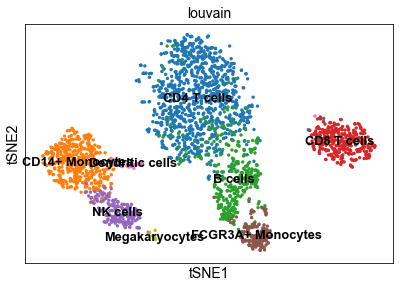

In [137]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', save='.pdf')

saving figure to file ./figures/tsne.pdf


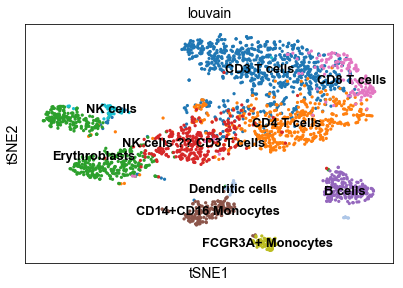

In [138]:
sc.pl.tsne(adata2, color='louvain', legend_loc='on data', save='.pdf')

saving figure to file ./figures/violin.pdf


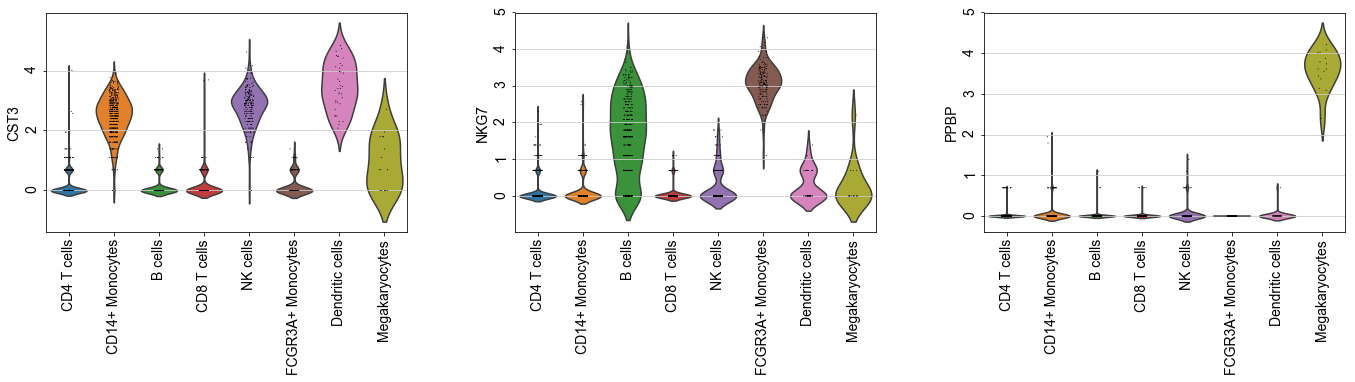

In [139]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain', rotation=90, save='.pdf')

saving figure to file ./figures/violin.pdf


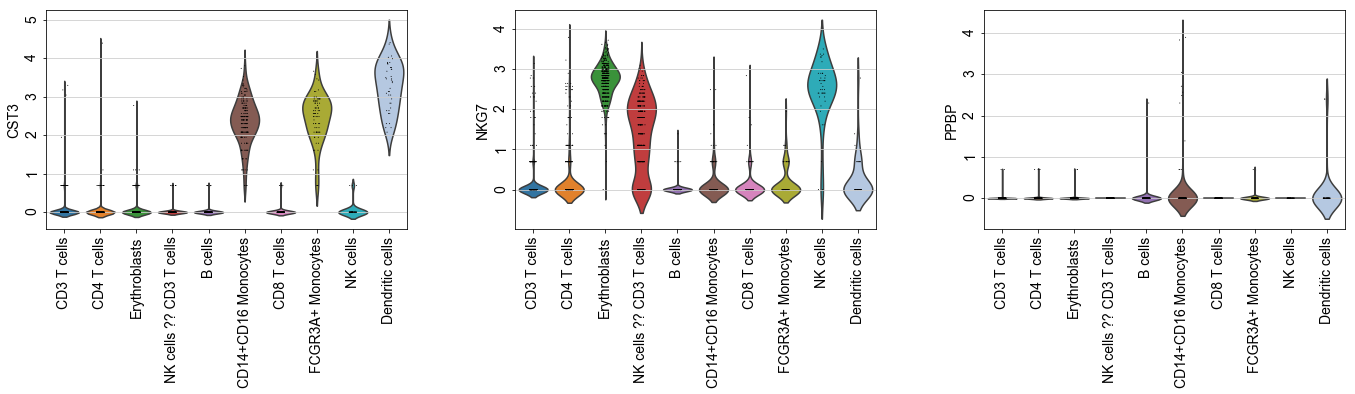

In [140]:
sc.pl.violin(adata2, ['CST3', 'NKG7', 'PPBP'], groupby='louvain', rotation=90, save='.pdf')

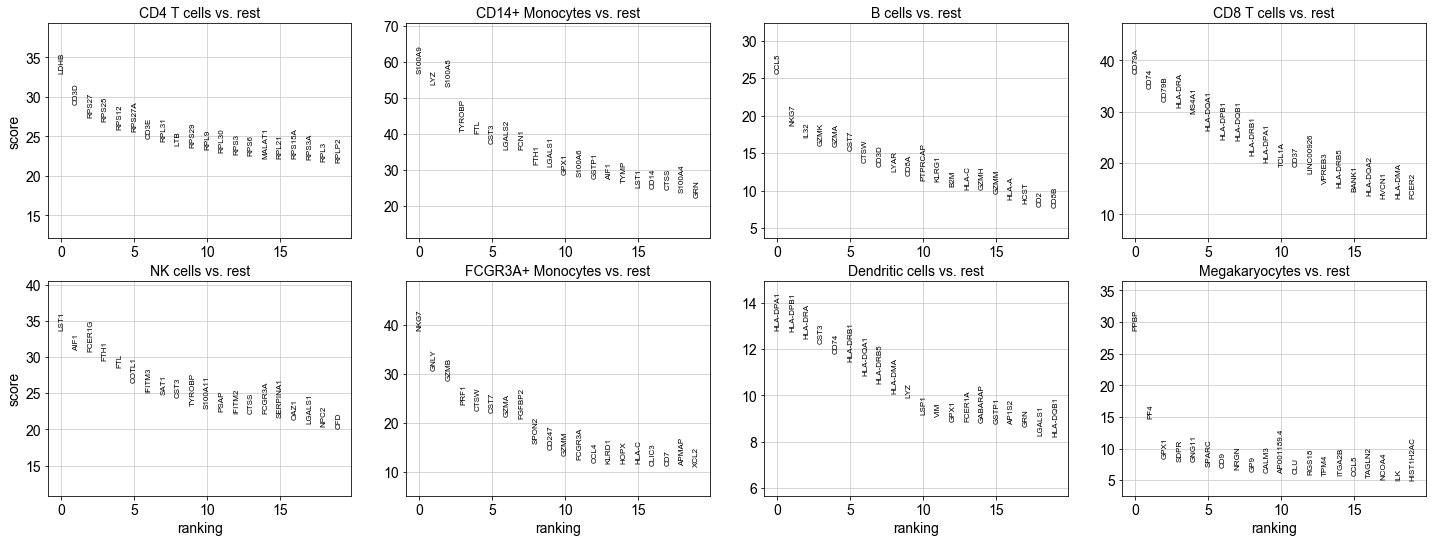

In [141]:
sc.pl.rank_genes_groups(adata, n_genes=20)

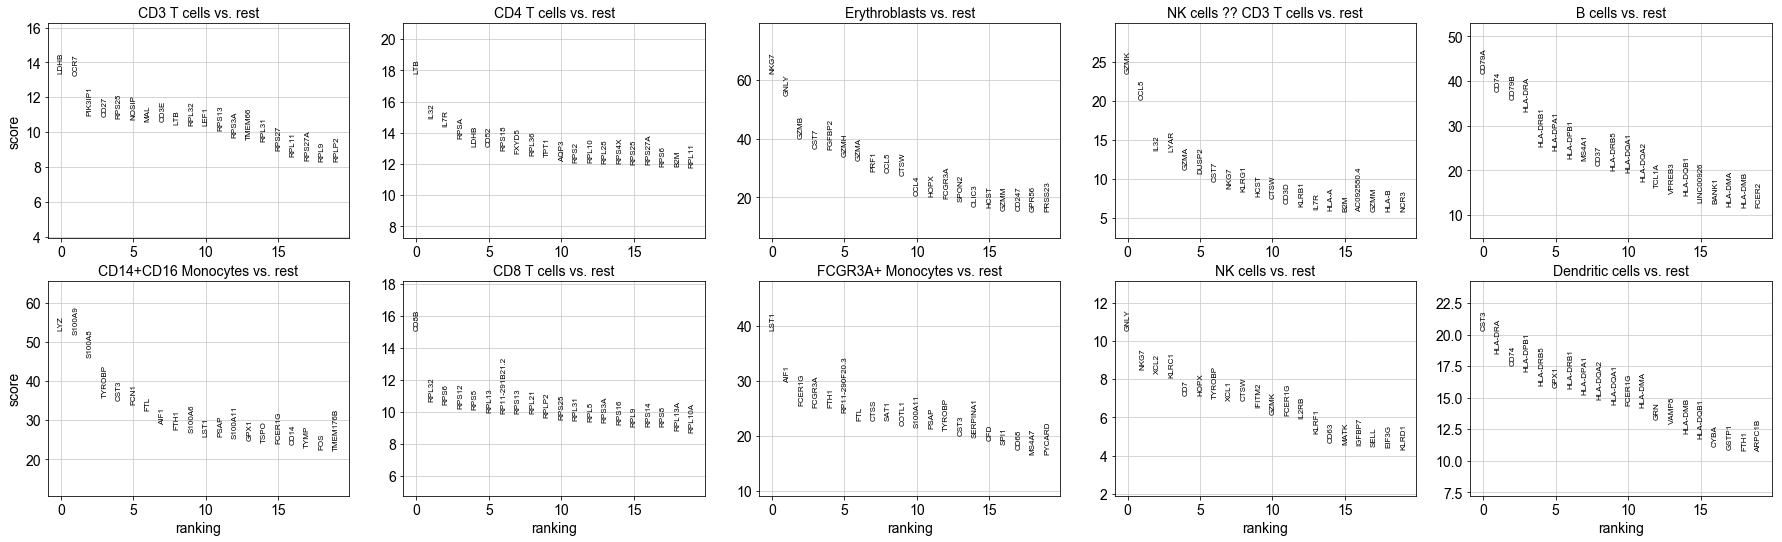

In [142]:
sc.pl.rank_genes_groups(adata2, n_genes=20)

Our AnnData now accumlated the following annotations.

In [143]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'var_ensemble', 'n_cells'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [144]:
adata2

AnnData object with n_obs × n_vars = 2849 × 2142 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'var_ensemble', 'n_cells'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [145]:
adata.write(results_file)

In [146]:
adata2.write(results_file2)

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

In [147]:
!h5ls './write/pmbc3k.h5ad'

X                        Dataset {2638, 1838}
obs                      Dataset {2638}
obsm                     Dataset {2638}
raw.X                    Group
raw.var                  Dataset {13714}
uns                      Group
var                      Dataset {1838}
varm                     Dataset {1838}


In [148]:
!h5ls './write/pmbc3k2.h5ad'

X                        Dataset {2849, 2142}
obs                      Dataset {2849}
obsm                     Dataset {2849}
raw.X                    Group
raw.var                  Dataset {13067}
uns                      Group
var                      Dataset {2142}
varm                     Dataset {2142}


If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix.

In [149]:
adata.X = None
adata.write('./write/pmbc3k_withoutX.h5ad')

In [150]:
adata2.X = None
adata2.write('./write/pmbc3k_withoutX2.h5ad')

If you want to export to "csv", you have the following options:

In [151]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

In [152]:
# Export single fields of the annotation of observations
# adata2.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata2.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata2.write_csvs(results_file2[:-5], )